# Synthetic data generation with GAN and VAE neural networks for a system of making strategically grounded decisions

## Setup Environment

In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
# Time module
import time
import warnings #todo exclude
# Data structures and analysis tools
import pandas as pd
# Numerical computing
import numpy as np
# Plots and visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
# Statistical functions, time-series models
from scipy.stats import (
    boxcox,
    ks_2samp,
    entropy,
    wasserstein_distance,
    chi2_contingency
)
# Seasonal ARIMA time-series forecasting
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Transformer logic
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    FunctionTransformer
)
# Principal component analysis
from sklearn.decomposition import PCA
# Logistic Regression classifier
from sklearn.linear_model import LogisticRegression
# Evaluation metrics(Scikit-learn)
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
    roc_curve
)
# Generation of a string data type
from faker import Faker
# Project modules
from gan import GAN, GanConfig, TrainingConfig as GanTrainingConfig, SchedulerConfig
from vae import VAE, VaeConfig, TrainingConfig as VaeTrainingConfig
from models.enums import DataType
from models.field_metadata import FieldMetadata

## Airline Dataset Overview

In [2]:
airline_dataset = pd.read_csv('datasets/airline-passenger-satisfaction.csv', parse_dates=['Date']).dropna()
print(f"Rows count in dataset: {airline_dataset.shape[0]}")
print(f"Column amount: {airline_dataset.shape[1]}")
display(airline_dataset.head(10))

Rows count in dataset: 103594
Column amount: 25


City       Date  Gender      Customer Type  Age   Type of Travel  \
0       Austin 2019-07-13    Male     Loyal Customer   13  Personal Travel   
1     San Jose 2017-07-26    Male  disloyal Customer   25  Business travel   
2      Seattle 2018-08-27  Female     Loyal Customer   26  Business travel   
3  San Antonio 2018-04-21  Female     Loyal Customer   25  Business travel   
4       Austin 2019-05-30    Male     Loyal Customer   61  Business travel   
5      Seattle 2018-09-23  Female     Loyal Customer   26  Personal Travel   
6       Dallas 2019-09-21    Male     Loyal Customer   47  Personal Travel   
7       Austin 2018-07-12  Female     Loyal Customer   52  Business travel   
8       Denver 2019-03-08  Female     Loyal Customer   41  Business travel   
9       Denver 2019-10-14    Male  disloyal Customer   20  Business travel   

      Class  Flight Distance  Inflight wifi service  \
0  Eco Plus              460                      3   
1  Business              235                      3   
2  Business             1142                      2   
3  Business              562                      2   
4  Business              214                      3   
5       Eco             1180                      3   
6       Eco             1276                      2   
7  Business             2035                      4   
8  Business              853                      1   
9       Eco             1061                      3   

   Departure or Arrival time convenient  ...  Inflight entertainment  \
0                                     4  ...                       5   
1                                     2  ...                       1   
2                                     2  ...                       5   
3                                     5  ...                       2   
4                                     3  ...                       3   
5                                     4  ...                       1   
6                                     4  ...                       2   
7                                     3  ...                       5   
8                                     2  ...                       1   
9                                     3  ...                       2   

   On-board service  Leg room service  Baggage handling  Checkin service  \
0                 4                 3                 4                4   
1                 1                 5                 3                1   
2                 4                 3                 4                4   
3                 2                 5                 3                1   
4                 3                 4                 4                3   
5                 3                 4                 4                4   
6                 3                 3                 4                3   
7                 5                 5                 5                4   
8                 1                 2                 1                4   
9                 2                 3                 4                4   

   Inflight service  Cleanliness  Departure Delay in Minutes  \
0                 5            5                          25   
1                 4            1                           1   
2                 4            5                           0   
3                 4            2                          11   
4                 3            3                           0   
5                 4            1                           0   
6                 5            2                           9   
7                 5            4                           4   
8                 1            2                           0   
9                 3            2                           0   

   Arrival Delay in Minutes  is_satisfied  
0                      18.0             0  
1                       6.0             0  
2                       0.0             1  
3                       9.0       

#### Overview of dataset column info

In [3]:
print(airline_dataset.info())

<class 'pandas.core.frame.DataFrame'>
Index: 103594 entries, 0 to 103903
Data columns (total 25 columns):
 #   Column                                Non-Null Count   Dtype         
---  ------                                --------------   -----         
 0   City                                  103594 non-null  object        
 1   Date                                  103594 non-null  datetime64[ns]
 2   Gender                                103594 non-null  object        
 3   Customer Type                         103594 non-null  object        
 4   Age                                   103594 non-null  int64         
 5   Type of Travel                        103594 non-null  object        
 6   Class                                 103594 non-null  object        
 7   Flight Distance                       103594 non-null  int64         
 8   Inflight wifi service                 103594 non-null  int64         
 9   Departure or Arrival time convenient  103594 non-null  int64    

## Synthetic Data Generation

#### Metadata for GAN and VAE networks, that describe types of data and methods of their generation

In [4]:
airline_metadata = {
    'City': FieldMetadata(DataType.STRING, faker_method=Faker().city),
    'Date': FieldMetadata(DataType.DATETIME, datetime_format='%Y-%m-%d'),
    'Gender': FieldMetadata(DataType.CATEGORICAL),
    'Customer Type': FieldMetadata(DataType.CATEGORICAL),
    'Age': FieldMetadata(DataType.INTEGER),
    'Type of Travel': FieldMetadata(DataType.CATEGORICAL),
    'Class': FieldMetadata(DataType.CATEGORICAL),
    'Flight Distance': FieldMetadata(DataType.INTEGER),
    'Inflight wifi service': FieldMetadata(DataType.INTEGER),
    'Departure or Arrival time convenient': FieldMetadata(DataType.INTEGER),
    'Ease of Online booking': FieldMetadata(DataType.INTEGER),
    'Gate location': FieldMetadata(DataType.INTEGER),
    'Food and drink': FieldMetadata(DataType.INTEGER),
    'Online boarding': FieldMetadata(DataType.INTEGER),
    'Seat comfort': FieldMetadata(DataType.INTEGER),
    'Inflight entertainment': FieldMetadata(DataType.INTEGER),
    'On-board service': FieldMetadata(DataType.INTEGER),
    'Leg room service': FieldMetadata(DataType.INTEGER),
    'Baggage handling': FieldMetadata(DataType.INTEGER),
    'Checkin service': FieldMetadata(DataType.INTEGER),
    'Inflight service': FieldMetadata(DataType.INTEGER),
    'Cleanliness': FieldMetadata(DataType.INTEGER),
    'Departure Delay in Minutes': FieldMetadata(DataType.INTEGER),
    'Arrival Delay in Minutes': FieldMetadata(DataType.DECIMAL, decimal_places=1),
    'is_satisfied': FieldMetadata(DataType.BOOLEAN),
}

#### Define lists of columns by type for statistical analysis after data generation

In [5]:
airline_num_cols = [col for col, meta in airline_metadata.items() if meta.data_type in {DataType.INTEGER, DataType.DECIMAL}]
airline_cat_cols = [col for col, meta in airline_metadata.items() if meta.data_type in {DataType.CATEGORICAL, DataType.BOOLEAN}]
airline_datetime_cols = [col for col, meta in airline_metadata.items() if meta.data_type == DataType.DATETIME]
airline_string_cols = [col for col, meta in airline_metadata.items() if meta.data_type == DataType.STRING]

#### Training process of GAN and VAE networks

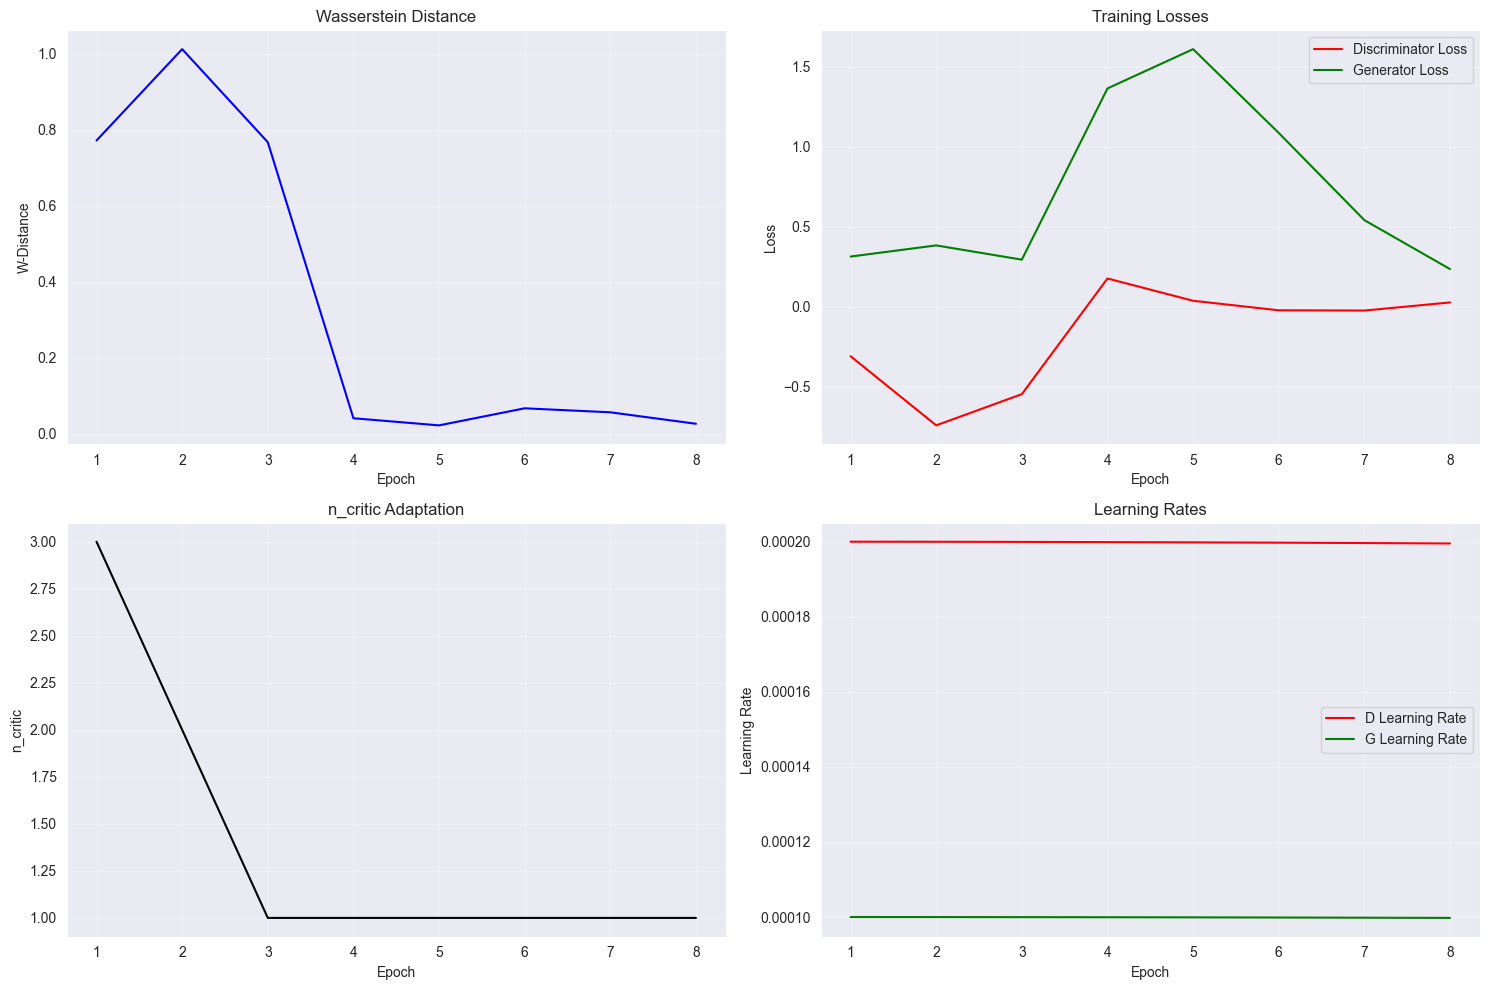

Training completed in 78.05 seconds


In [9]:
start_time = time.time()

cfg = GanConfig(training=GanTrainingConfig(epochs=250, verbose=True),scheduler=SchedulerConfig(patience=5))
# Creating a GAN pipeline with GAN Config class
gan_model = GAN(airline_dataset, airline_metadata, cfg)
# Training a GAN model with training plots
gan_model.fit()
# Generating synthetic data
airline_gan_dataset = gan_model.generate(len(airline_dataset)//2)

print(f"Training completed in {time.time() - start_time:.2f} seconds")

D:\stuff\diplom\vae\pipeline.py:141: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_numpy.cpp:209.)
  cats.append(torch.eye(dim, device=DEVICE)[idx])


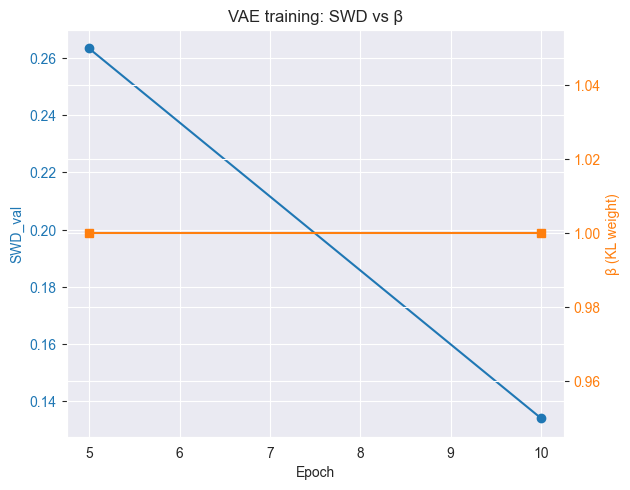

Training completed in 92.57 seconds


In [7]:
warnings.simplefilter(action="ignore", category=UserWarning)
start_time = time.time()
# Creating a VAE pipeline
vae_model = VAE(airline_dataset, airline_metadata, VaeConfig(training=VaeTrainingConfig(epochs=10, verbose=True)))
# Training a VAE model with training plots
vae_model.fit()
# Generating synthetic data
airline_vae_dataset = vae_model.generate(len(airline_dataset)//2)

print(f"Training completed in {time.time() - start_time:.2f} seconds")

## Quality Analysis

#### Original dataset - numeric columns

In [8]:
display(airline_dataset[airline_num_cols].describe())

Age  Flight Distance  Inflight wifi service  \
count  103594.000000    103594.000000          103594.000000   
mean       39.380466      1189.325202               2.729753   
std        15.113125       997.297235               1.327866   
min         7.000000        31.000000               0.000000   
25%        27.000000       414.000000               2.000000   
50%        40.000000       842.000000               3.000000   
75%        51.000000      1743.000000               4.000000   
max        85.000000      4983.000000               5.000000   

       Departure or Arrival time convenient  Ease of Online booking  \
count                         103594.000000           103594.000000   
mean                               3.060081                2.756984   
std                                1.525233                1.398934   
min                                0.000000                0.000000   
25%                                2.000000                2.000000   
50%                                3.000000                3.000000   
75%                                4.000000                4.000000   
max                                5.000000                5.000000   

       Gate location  Food and drink  Online boarding   Seat comfort  \
count  103594.000000   103594.000000    103594.000000  103594.000000   
mean        2.977026        3.202126         3.250497       3.439765   
std         1.277723        1.329401         1.349433       1.318896   
min         0.000000        0.000000         0.000000       0.000000   
25%         2.000000        2.000000         2.000000       2.000000   
50%         3.000000        3.000000         3.000000       4.000000   
75%         4.000000        4.000000         4.000000       5.000000   
max         5.000000        5.000000         5.000000       5.000000   

       Inflight entertainment  On-board service  Leg room service  \
count           103594.000000     103594.000000     103594.000000   
mean                 3.358341          3.382609          3.351401   
std                  1.333030          1.288284          1.315409   
min                  0.000000          0.000000          0.000000   
25%                  2.000000          2.000000          2.000000   
50%                  4.000000          4.000000          4.000000   
75%                  4.000000          4.000000          4.000000   
max                  5.000000          5.000000          5.000000   

       Baggage handling  Checkin service  Inflight service    Cleanliness  \
count     103594.000000    103594.000000     103594.000000  103594.000000   
mean           3.631687         3.304323          3.640761       3.286397   
std            1.181051         1.265396          1.175603       1.312194   
min            1.000000         0.000000          0.000000       0.000000   
25%            3.000000         3.000000          3.000000       2.000000   
50%            4.000000         3.000000          4.000000       3.000000   
75%            5.000000         4.000000          5.000000       4.000000   
max            5.000000         5.000000          5.000000       5.000000   

       Departure Delay in Minutes  Arrival Delay in Minutes  
count               103594.000000             103594.000000  
mean                    14.747939                 15.178678  
std                     38.116737                 38.698682  
min                      0.000000                  0.000000  
25%                      0.000000                  0.000000  
50%                      0.000000                  0.000000  
75%                     12.000000                 13.000000  
max                   1592.000000               1584.000000

#### Статистичні метрики оригінального та синтетичних датасетів

##### Utility Methods for statistic comparison

In [36]:
def _kl_divergence(hist_ref, hist_cmp, eps=1e-10):
    """Symmetric KL with smoothing to avoid log(0)"""
    return 0.5 * (
        entropy(hist_ref + eps, hist_cmp + eps) +
        entropy(hist_cmp + eps, hist_ref + eps)
    )

def _safe_hist(series, bins=50):
    """Histogram with fixed bin-edges (for KL and Wasserstein)."""
    counts, edges = np.histogram(series, bins=bins, density=True)
    return counts, edges

def _value_counts(series):
    """Consistent index type (str) so union / reindex is stable."""
    return series.astype('object').astype(str).value_counts()


In [37]:
numeric_metrics = []

for col, meta in airline_metadata.items():
    if col not in airline_num_cols:
        continue

    real = airline_dataset[col].to_numpy()
    gan  = airline_gan_dataset[col].to_numpy()
    vae  = airline_vae_dataset[col].to_numpy()

    # Wasserstein
    w_gan, w_vae = wasserstein_distance(real, gan), wasserstein_distance(real, vae)

    # KS
    ks_gan, ks_vae = ks_2samp(real, gan), ks_2samp(real, vae)

    # KL on equal bins
    hist_r, bins  = _safe_hist(real)
    hist_g, _     = np.histogram(gan, bins=bins, density=True)
    hist_v, _     = np.histogram(vae, bins=bins, density=True)
    kl_gan, kl_vae = _kl_divergence(hist_r, hist_g), _kl_divergence(hist_r, hist_v)

    numeric_metrics.append({
        "field": col,
        "W_gan":  w_gan,
        "KS_gan_stat": ks_gan.statistic,  "KS_gan_p": ks_gan.pvalue,
        "KL_gan": kl_gan,
        "W_vae":  w_vae,
        "KS_vae_stat": ks_vae.statistic,  "KS_vae_p": ks_vae.pvalue,
        "KL_vae": kl_vae,
    })

display(pd.DataFrame(numeric_metrics).set_index("field").sort_index())


W_gan  KS_gan_stat      KS_gan_p  \
field                                                                        
Age                                    0.438520     0.015522  1.174148e-07   
Arrival Delay in Minutes               0.799950     0.051383  1.123824e-79   
Baggage handling                       0.047271     0.018466  1.167151e-10   
Checkin service                        0.102419     0.033834  8.876579e-35   
Cleanliness                            0.029567     0.011593  1.846391e-04   
Departure Delay in Minutes             0.670521     0.050447  8.204729e-77   
Departure or Arrival time convenient   0.062378     0.021208  6.361387e-14   
Ease of Online booking                 0.042194     0.015899  5.185472e-08   
Flight Distance                       53.198245     0.033371  7.634941e-34   
Food and drink                         0.020995     0.012481  4.214663e-05   
Gate location                          0.044346     0.018322  1.686390e-10   
Inflight entertainment                 0.033670     0.018621  7.856948e-11   
Inflight service                       0.060052     0.020966  1.285123e-13   
Inflight wifi service                  0.038574     0.012385  4.974964e-05   
Leg room service                       0.092544     0.029838  3.843741e-27   
On-board service                       0.058864     0.022405  1.726374e-15   
Online boarding                        0.057339     0.017260  2.294070e-09   
Seat comfort                           0.034568     0.015908  5.076631e-08   

                                        KL_gan      W_vae  KS_vae_stat  \
field                                                                    
Age                                   0.016341   0.398150     0.013871   
Arrival Delay in Minutes              0.013866   2.807518     0.074396   
Baggage handling                      0.003099   0.132025     0.040186   
Checkin service                       0.010985   0.095565     0.029683   
Cleanliness                           0.002777   0.124708     0.038506   
Departure Delay in Minutes            0.012006   2.705446     0.074657   
Departure or Arrival time convenient  0.008005   0.135336     0.043699   
Ease of Online booking                0.005466   0.149748     0.042522   
Flight Distance                       0.016516  22.040070     0.025281   
Food and drink                        0.010519   0.155540     0.055843   
Gate location                         0.002500   0.067571     0.025388   
Inflight entertainment                0.003484   0.201112     0.079628   
Inflight service                      0.003657   0.121503     0.042753   
Inflight wifi service                 0.003836   0.166129     0.049839   
Leg room service                      0.007287   0.142122     0.045591   
On-board service                      0.003790   0.150897     0.048893   
Online boarding                       0.003807   0.158542     0.051605   
Seat comfort                          0.001959   0.155598     0.047841   

                                           KS_vae_p    KL_vae  
field                                                          
Age                                    3.354144e-06  0.023561  
Arrival Delay in Minutes              1.172960e-166  0.014316  
Baggage handling                       6.861783e-49  0.017362  
Checkin service                        7.254905e-27  0.008428  
Cleanliness                            6.367095e-45  0.015815  
Departure Delay in Minutes            7.964247e-168  0.013003  
Departure or Arrival time convenient   9.729034e-58  0.018495  
Ease of Online booking                 1.087529e-54  0.021111  
Flight Distance                        1.321204e-19  0.008993  
Food and drink                         4.879325e-94  0.028363  
Gate location                          9.110113e-20  0.005481  
Inflight entertainment                6.819863e-191  0.049523  
Inflight service                       2.775562e-55  0.015830  
Inflight wifi service                  5

In [38]:
categorical_metrics = []

for col, meta in airline_metadata.items():
    if col not in airline_cat_cols:
        continue

    real_ct = _value_counts(airline_dataset[col])
    gan_ct  = _value_counts(airline_gan_dataset[col])
    vae_ct  = _value_counts(airline_vae_dataset[col])

    # Common support
    cats = sorted(set(real_ct.index) | set(gan_ct.index) | set(vae_ct.index))

    # MAE on counts
    mae_gan = mean_absolute_error(real_ct.reindex(cats, fill_value=0), gan_ct.reindex(cats, fill_value=0))
    mae_vae = mean_absolute_error(real_ct.reindex(cats, fill_value=0), vae_ct.reindex(cats, fill_value=0))

    # χ² contingency
    cont_gan = np.vstack([
        real_ct.reindex(cats, fill_value=0),
        gan_ct.reindex(cats,  fill_value=0)
    ])
    cont_vae = np.vstack([
        real_ct.reindex(cats, fill_value=0),
        vae_ct.reindex(cats,  fill_value=0)
    ])

    chi_g_stat, chi_g_p, _, _ = chi2_contingency(cont_gan)
    chi_v_stat, chi_v_p, _, _ = chi2_contingency(cont_vae)

    categorical_metrics.append({
        "field": col,
        "MAE_gan": mae_gan,
        "Chi2_gan_stat": chi_g_stat, "Chi2_gan_p": chi_g_p,
        "MAE_vae": mae_vae,
        "Chi2_vae_stat": chi_v_stat, "Chi2_vae_p": chi_v_p,
    })

display(pd.DataFrame(categorical_metrics).set_index("field").sort_index())

MAE_gan  Chi2_gan_stat  Chi2_gan_p       MAE_vae  \
field                                                                   
Class           17265.666667       0.831902    0.659712  17265.666667   
Customer Type   25898.500000       1.089197    0.296649  25898.500000   
Gender          25898.500000       0.063984    0.800306  25898.500000   
Type of Travel  25898.500000       2.897692    0.088706  25898.500000   
is_satisfied    25898.500000       0.575319    0.448153  25898.500000   

                Chi2_vae_stat     Chi2_vae_p  
field                                         
Class              571.889532  6.542834e-125  
Customer Type      154.476110   1.822557e-35  
Gender               0.887124   3.462578e-01  
Type of Travel      15.111208   1.013597e-04  
is_satisfied         0.140391   7.078922e-01

#### Analytics on string data type generation

In [1]:
# Get value counts for each dataset's city column
orig = airline_dataset['City'].value_counts(normalize=True).nlargest(20)
gan = airline_gan_dataset['City'].value_counts(normalize=True).nlargest(20)
vae = airline_vae_dataset['City'].value_counts(normalize=True).nlargest(20)

# Create 1x3 subplot
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot Original distribution
orig.plot(kind='bar', ax=axes[0], width=0.8, edgecolor='black')
axes[0].set_title('City: Original (Top 20)')
axes[0].set_ylabel('Proportion')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')

# Plot GAN distribution
gan.plot(kind='bar', ax=axes[1], width=0.8, edgecolor='black')
axes[1].set_title('City: GAN (Top 20)')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')

# Plot VAE distribution
vae.plot(kind='bar', ax=axes[2], width=0.8, edgecolor='black')
axes[2].set_title('City: VAE (Top 20)')
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

NameError: name 'airline_dataset' is not defined

#### Comparing distributions of numeric columns in original and synthetic datasets

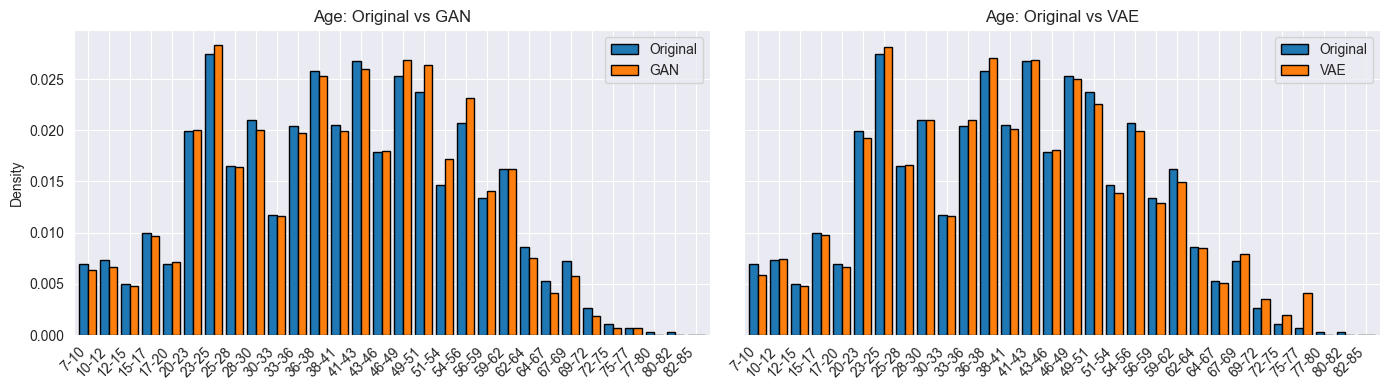

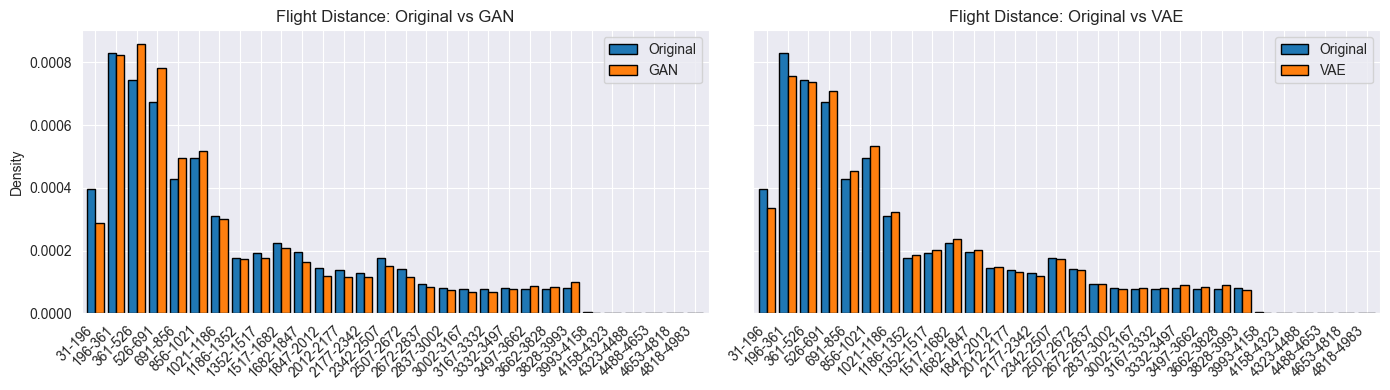

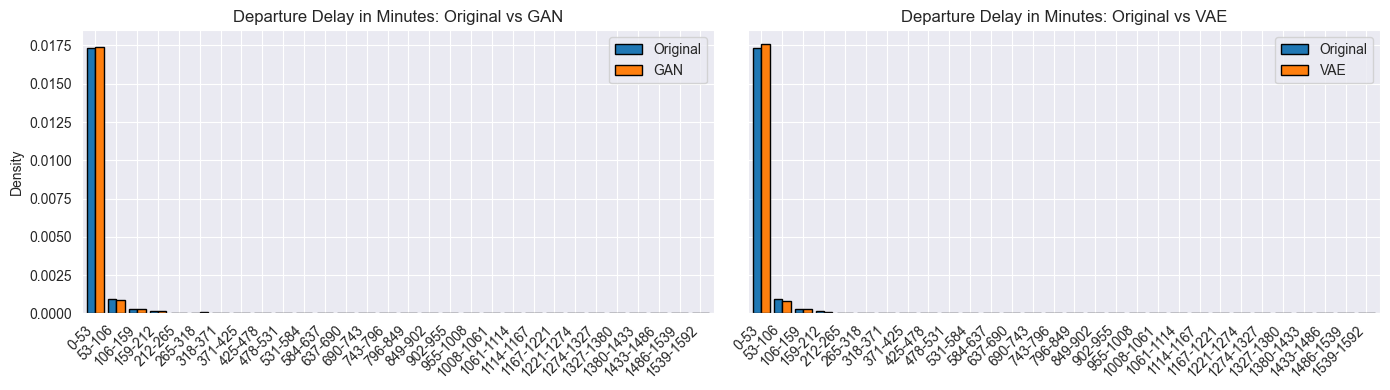

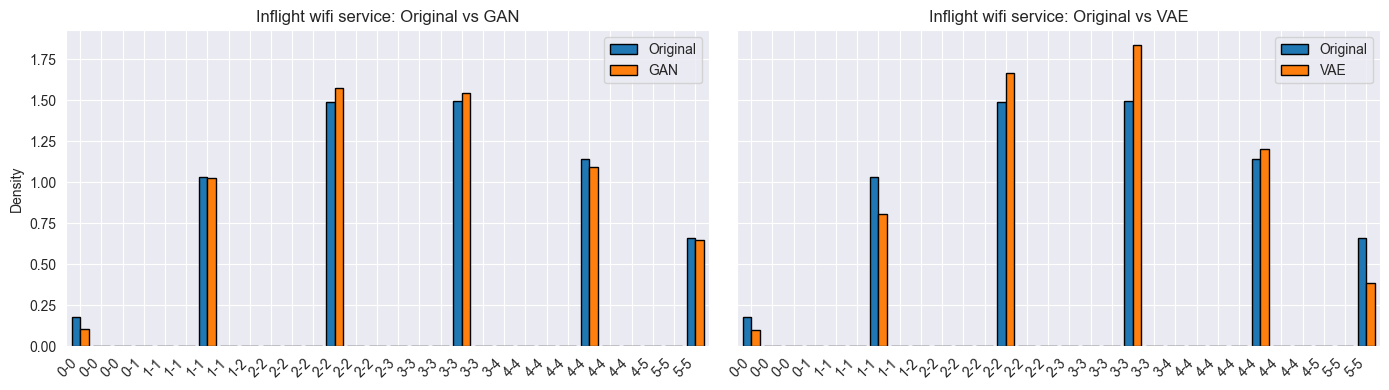

In [40]:
for col in ['Age', 'Flight Distance', 'Departure Delay in Minutes', 'Inflight wifi service']:
    orig_vals = airline_dataset[col].dropna().values
    gan_vals  = airline_gan_dataset[col].dropna().values
    vae_vals  = airline_vae_dataset[col].dropna().values

    # Define common bins based on original data
    bins = np.histogram_bin_edges(orig_vals, bins=30)

    # Compute a normalized histogram (density) for each dataset
    orig_counts, _ = np.histogram(orig_vals, bins=bins, density=True)
    gan_counts,  _ = np.histogram(gan_vals,  bins=bins, density=True)
    vae_counts, _ = np.histogram(vae_vals, bins=bins, density=True)

    # Create bin labels
    bin_labels = [f"{bins[i]:.0f}-{bins[i+1]:.0f}" for i in range(len(bins)-1)]

    # Build DataFrames for plotting
    df_og = pd.DataFrame({'Original': orig_counts, 'GAN': gan_counts}, index=bin_labels)
    df_ov = pd.DataFrame({'Original': orig_counts, 'VAE': vae_counts}, index=bin_labels)

    # Plot side-by-side bar charts
    fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)

    df_og.plot(kind='bar', ax=axes[0], width=0.8, edgecolor='black')
    axes[0].set_title(f"{col}: Original vs GAN")
    axes[0].set_ylabel('Density')

    df_ov.plot(kind='bar', ax=axes[1], width=0.8, edgecolor='black')
    axes[1].set_title(f"{col}: Original vs VAE")

    for ax in axes:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        ax.legend()
    plt.tight_layout()
    plt.show()

#### Порівняння розподілів категоріальних колонок у оригінальному та синтетичних датасетах

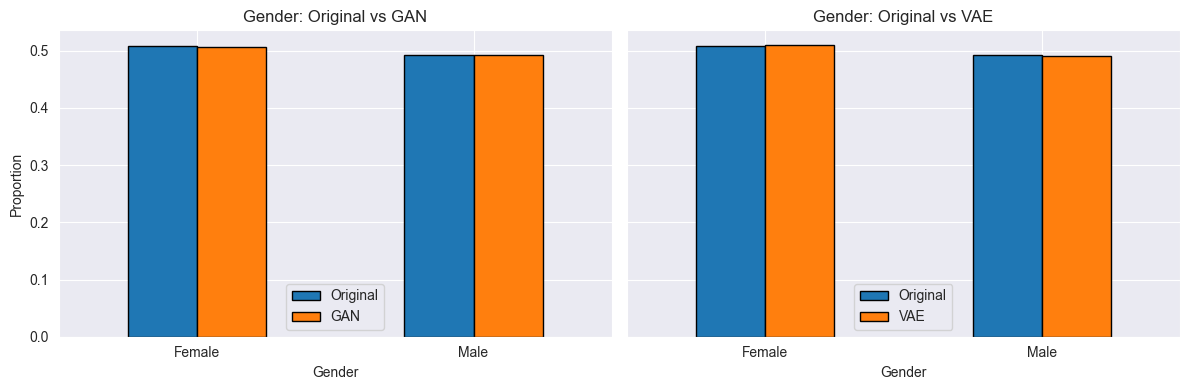

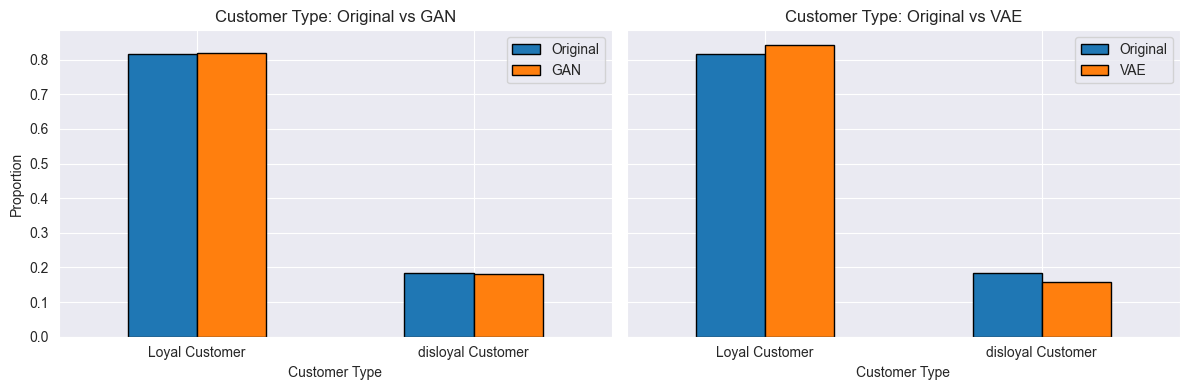

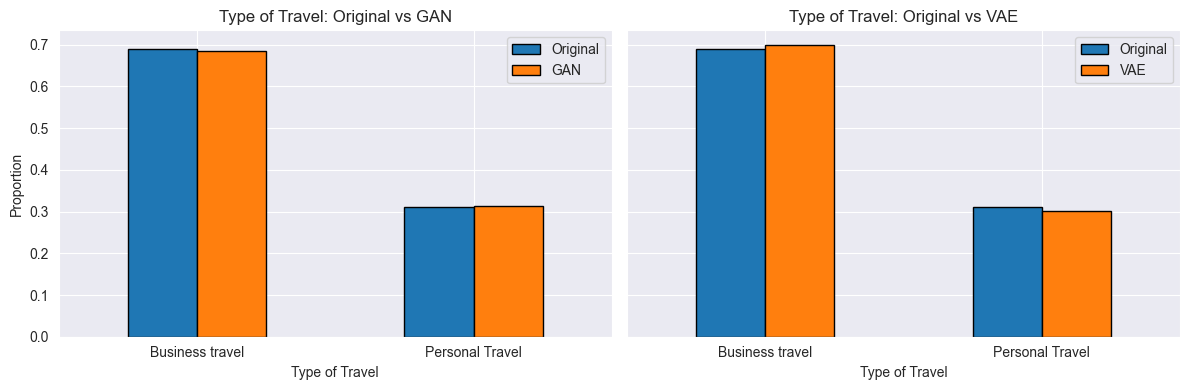

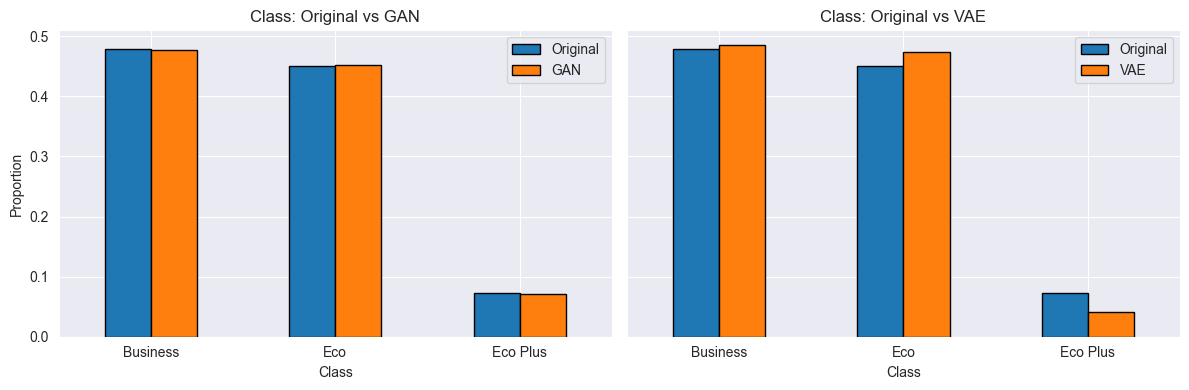

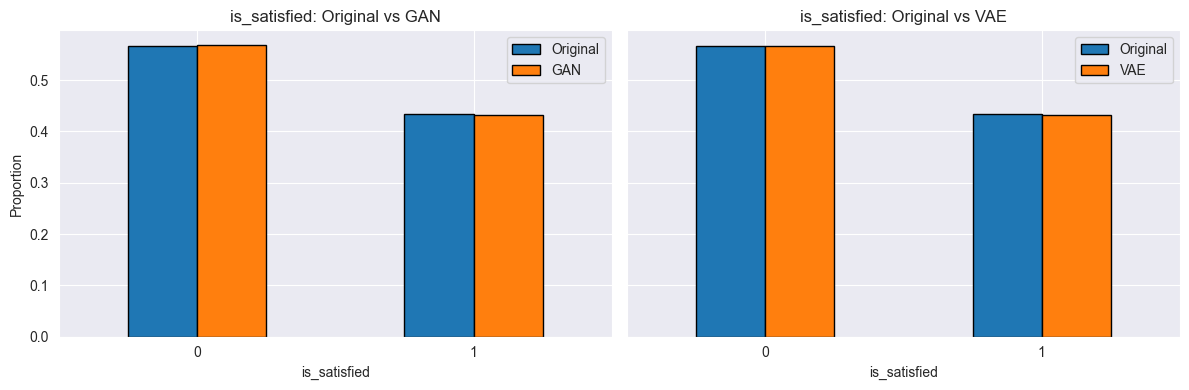

In [41]:
for col in airline_cat_cols:
    # Prepare normalized proportions as strings to avoid mixed-type ordering issues
    orig = airline_dataset[col].fillna('NaN').astype(str).value_counts(normalize=True).sort_index()
    gan  = airline_gan_dataset[col].fillna('NaN').astype(str).value_counts(normalize=True).reindex(orig.index, fill_value=0)
    vae  = airline_vae_dataset[col].fillna('NaN').astype(str).value_counts(normalize=True).reindex(orig.index, fill_value=0)

    # Build DataFrames for side-by-side bar plots
    df_gan_counts = pd.DataFrame({'Original': orig, 'GAN': gan})
    df_vae_counts = pd.DataFrame({'Original': orig, 'VAE': vae})

    # Create 1×2 subplot
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

    # Plot Original vs GAN
    df_gan_counts.plot(kind='bar', ax=axes[0], edgecolor='black')
    axes[0].set_title(f'{col}: Original vs GAN')
    axes[0].set_ylabel('Proportion')

    # Plot Original vs VAE
    df_vae_counts.plot(kind='bar', ax=axes[1], edgecolor='black')
    axes[1].set_title(f'{col}: Original vs VAE')

    # Tidy up tick labels
    for ax in axes:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
        ax.legend()

    plt.tight_layout()
    plt.show()


#### Utility methods for correlation matrixes (numeric-numeric and categorical-numeric)

In [42]:
def correlation_num_to_num_matrix_plot(df1, df2, columns, title_prefix=""):
    """
    Plots numeric-numeric correlations for Real vs Synthetic and their absolute difference.
    """
    corr_orig = df1[columns].corr()
    corr_gan  = df2[columns].corr()
    diff_gan  = (corr_orig - corr_gan).abs()

    # 2) Original heatmap
    plt.figure(figsize=(8,6))
    sns.heatmap(corr_orig, vmin=-1, vmax=1, cmap="vlag", annot=False, fmt=".2f")
    plt.title("Numeric-Numeric Correlation — Original")
    plt.tight_layout()
    plt.show()

    # 3) GAN heatmap
    plt.figure(figsize=(8,6))
    sns.heatmap(corr_gan, vmin=-1, vmax=1, cmap="vlag", annot=False, fmt=".2f")
    plt.title(f"Numeric-Numeric Correlation — {title_prefix}")
    plt.tight_layout()
    plt.show()

    # 4) Absolute-difference heatmap
    plt.figure(figsize=(8,6))
    sns.heatmap(diff_gan, vmin=0, vmax=1, cmap="rocket_r", annot=False, fmt=".2f")
    plt.title(f"Absolute Difference |Original – {title_prefix}|")
    plt.tight_layout()
    plt.show()

def correlation_ratio(categories, values):
    df = values.to_frame(name="x").join(categories.rename("g"))
    df = df.dropna(subset=["x", "g"])
    grand_mean = df["x"].mean()
    ss_between = sum(
        grp["x"].count() * (grp["x"].mean() - grand_mean)**2
        for _, grp in df.groupby("g")
    )
    ss_total = ((df["x"] - grand_mean)**2).sum()
    return ss_between / ss_total if ss_total > 0 else np.nan

def correlation_cat_num_matrix_plot(df_real, df_syn, num_cols, cat_cols,
                                    title_prefix="", squared=False):
    def _eta(col_cat, col_num):
        overall = col_num.mean()
        stats = col_num.groupby(col_cat, dropna=False).agg(['count', 'mean'])
        ss_between = (stats['count'] * (stats['mean'] - overall) ** 2).sum()
        ss_total   = ((col_num - overall) ** 2).sum()
        val = ss_between / ss_total if ss_total > 0 else np.nan
        return val if squared else np.sqrt(val)

    eta_real = pd.DataFrame(index=cat_cols, columns=num_cols, dtype=float)
    eta_syn  = pd.DataFrame(index=cat_cols, columns=num_cols, dtype=float)

    for c in cat_cols:
        for n in num_cols:
            eta_real.loc[c, n] = _eta(df_real[c], df_real[n])
            eta_syn.loc[c, n]  = _eta(df_syn[c],  df_syn[n])

    eta_diff = (eta_real - eta_syn).abs()

    for mat, ttl in zip([eta_real, eta_syn, eta_diff],
                        ["η Real" if not squared else "η² Real",
                         "η Synthetic" if not squared else "η² Synthetic",
                         "Abs diff"]):
        fig, ax = plt.subplots(figsize=(1.5*len(num_cols),
                                        0.5*len(cat_cols)+3))
        sns.heatmap(mat, mask=mat.isna(), annot=True, fmt=".2f",
                    xticklabels=num_cols, yticklabels=cat_cols,
                    cmap="rocket_r", vmin=0, vmax=1,
                    cbar_kws={'label': 'η' if not squared else 'η²'},
                    ax=ax)
        ax.set_title(f"{ttl} ({title_prefix})")
        plt.tight_layout()
        plt.show()

    return eta_real, eta_syn, eta_diff

#### Comparison of correlation matrices of numeric columns in original and synthetic datasets

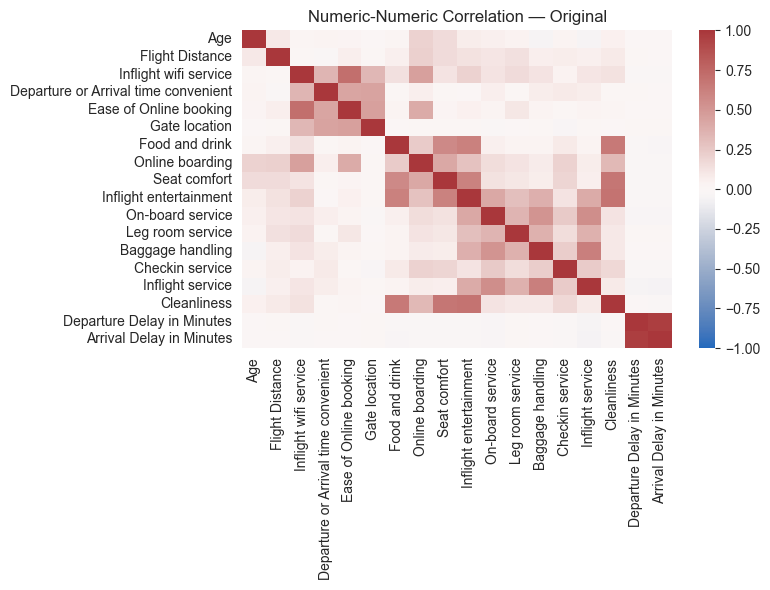

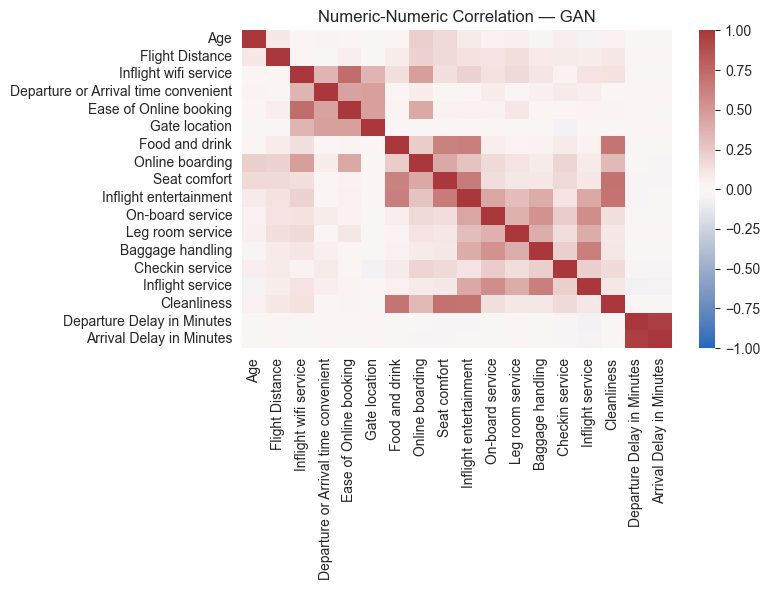

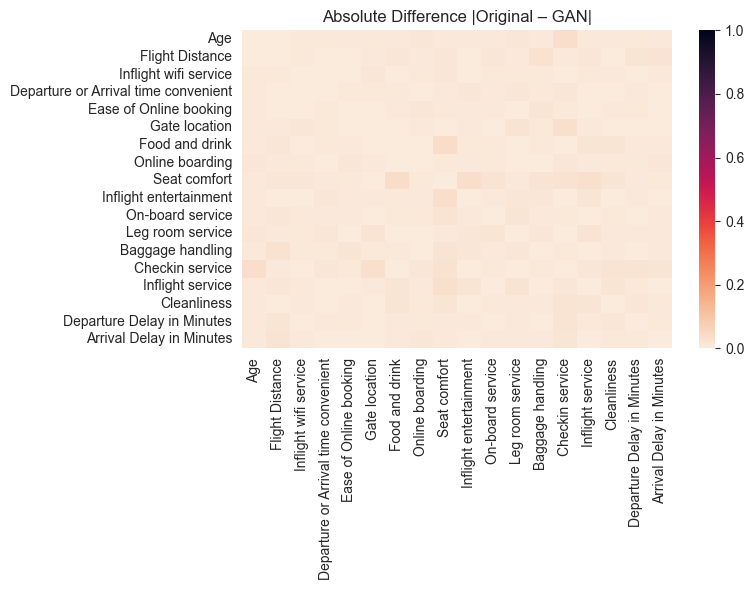

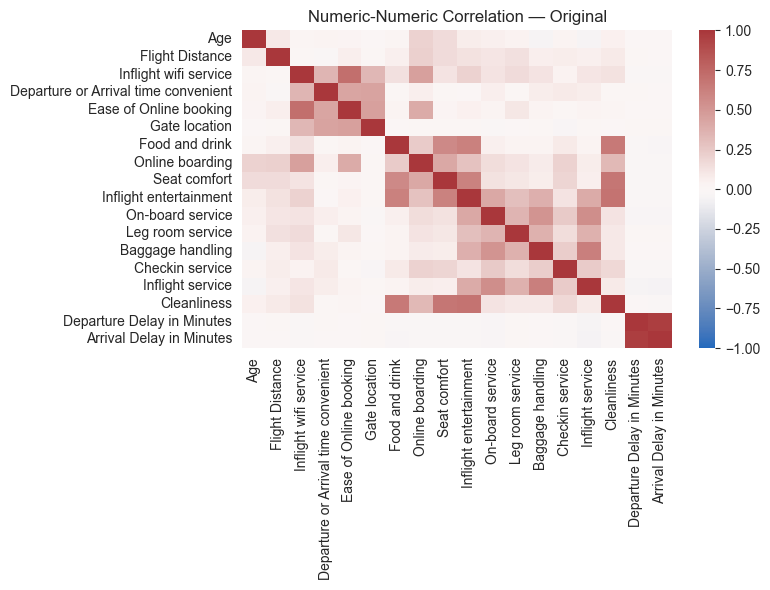

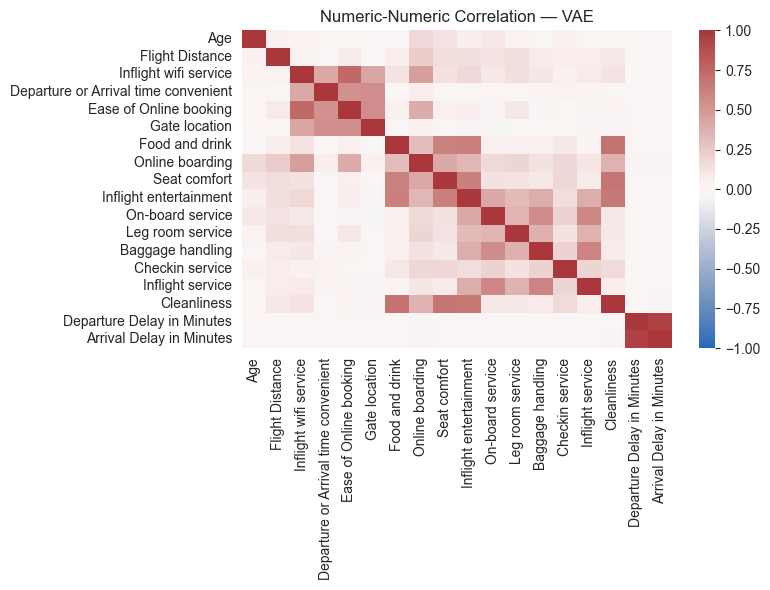

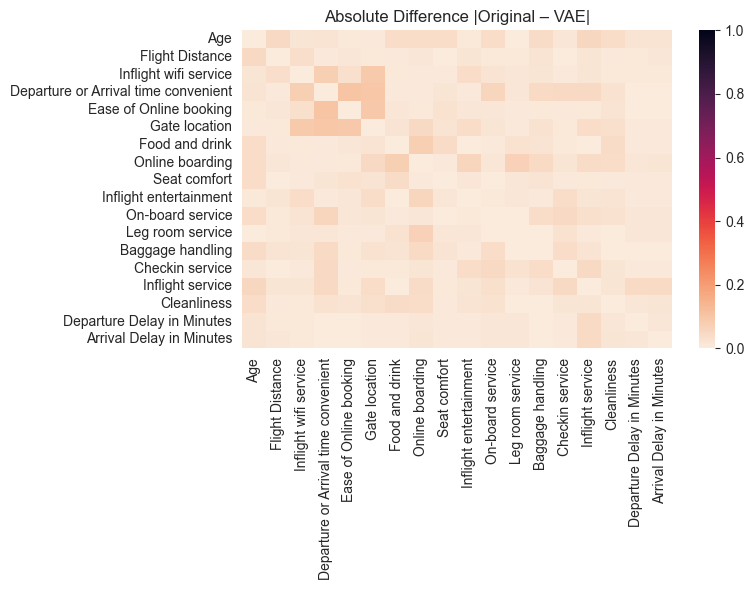

In [43]:
correlation_num_to_num_matrix_plot(airline_dataset, airline_gan_dataset, airline_num_cols, "GAN")
correlation_num_to_num_matrix_plot(airline_dataset, airline_vae_dataset, airline_num_cols, "VAE")

#### Comparison of correlation matrices of categorical columns in original and synthetic datasets

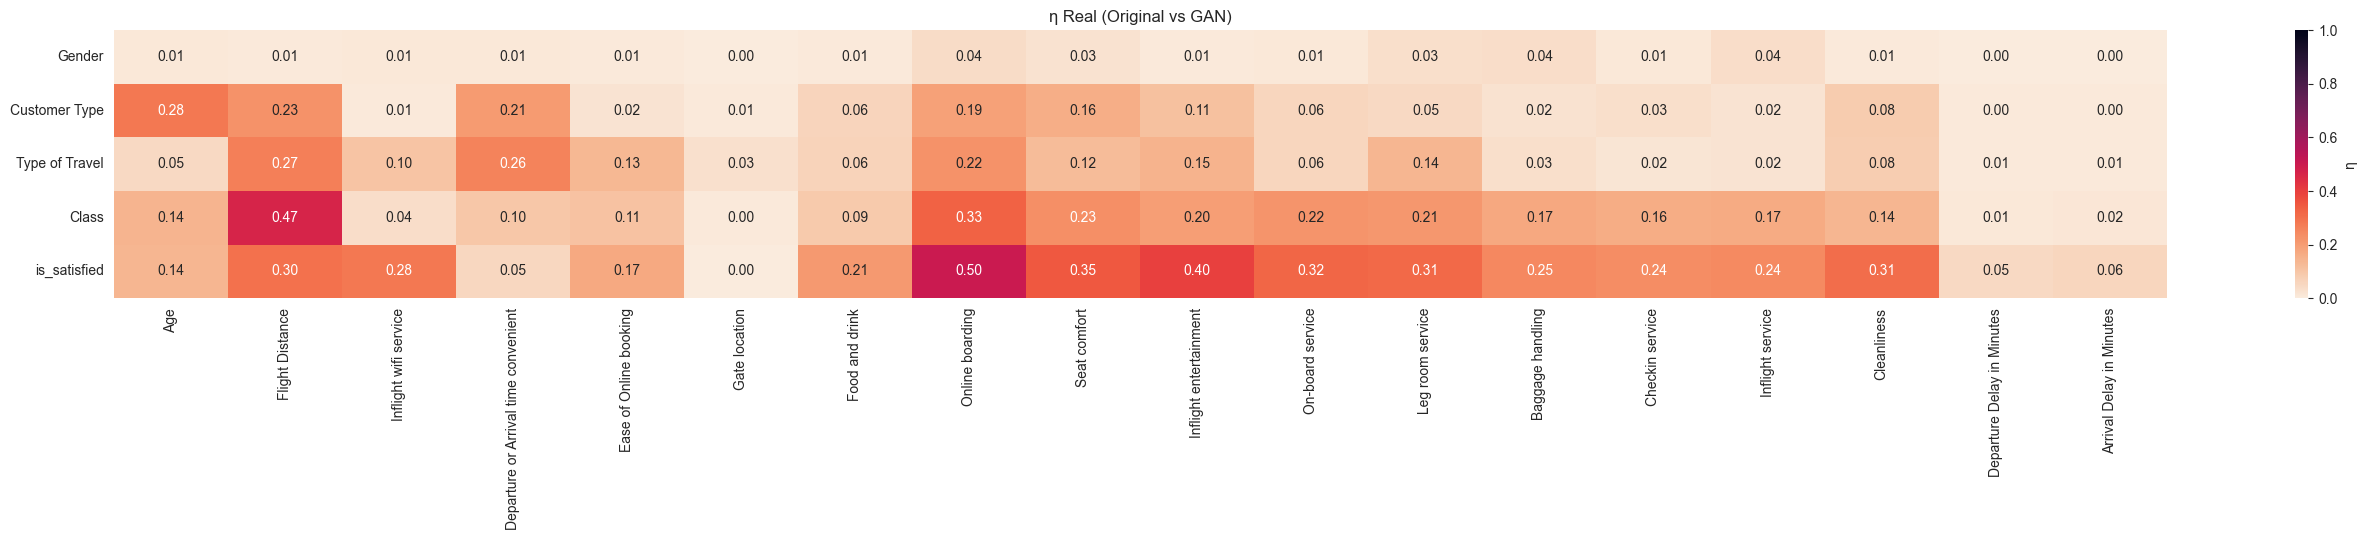

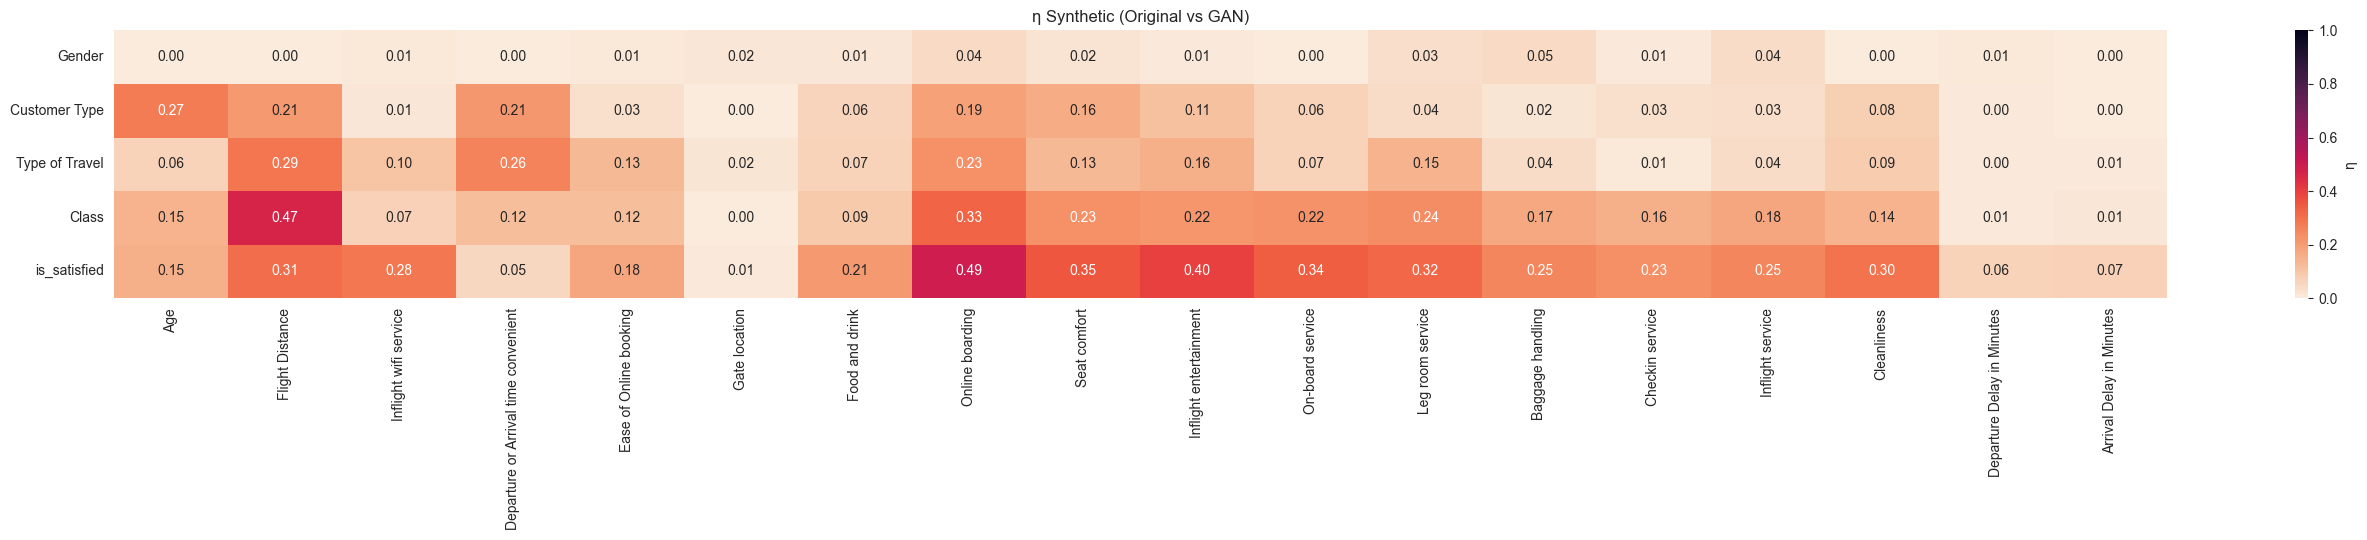

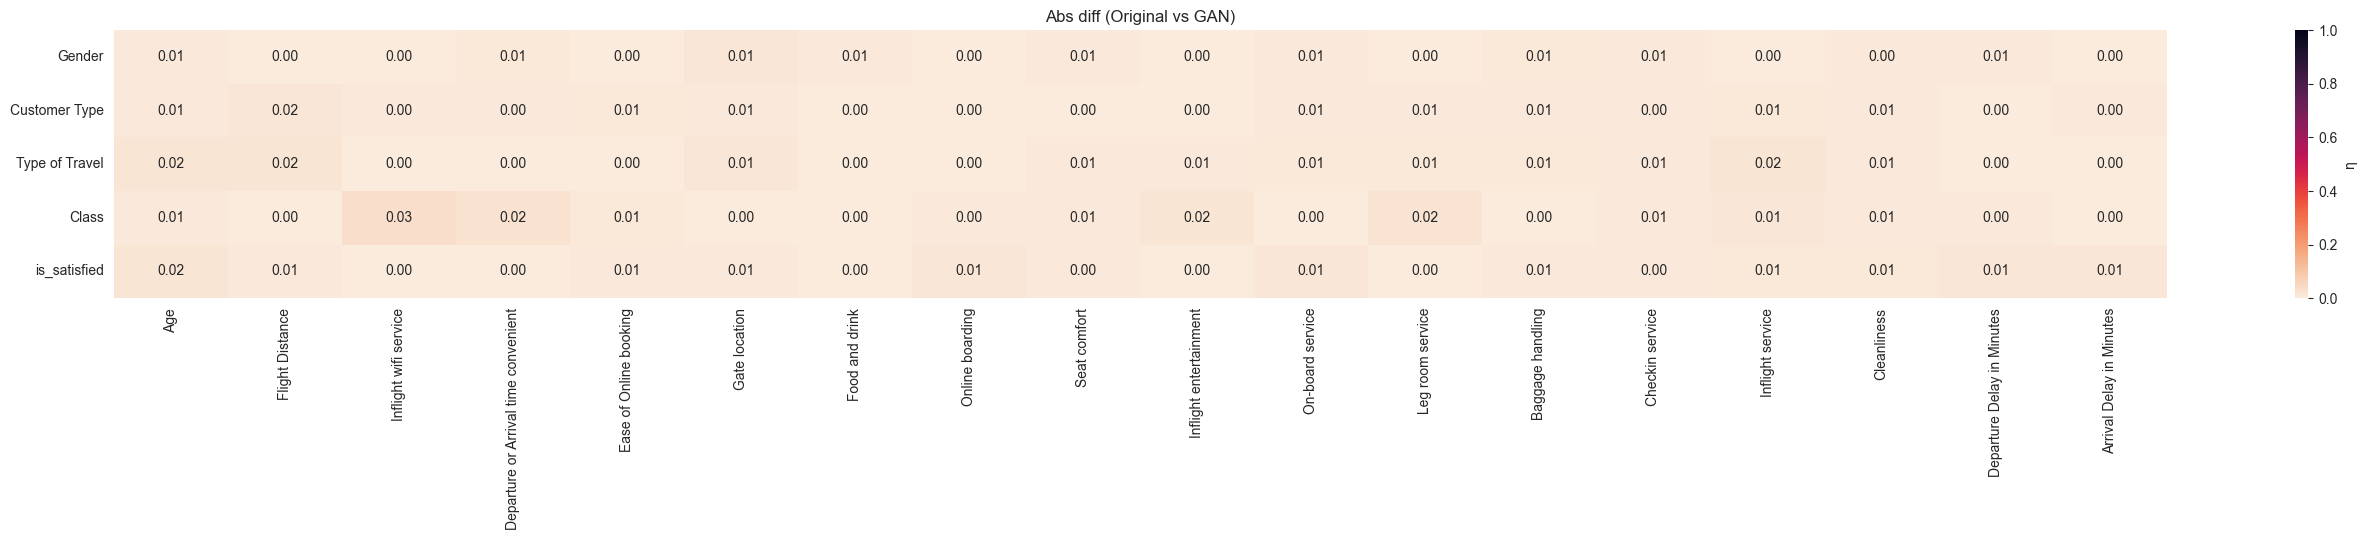

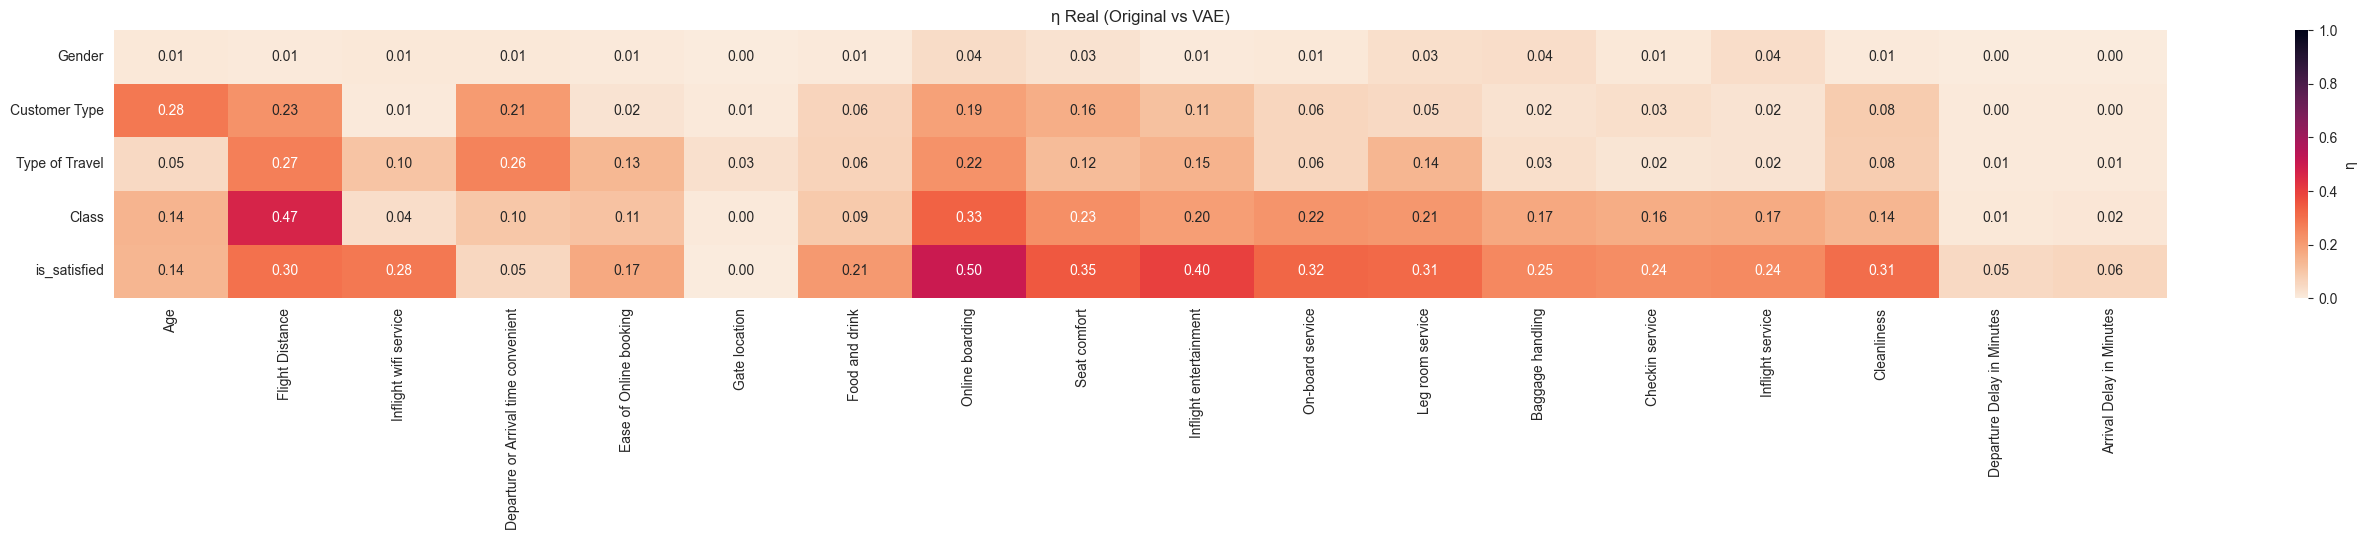

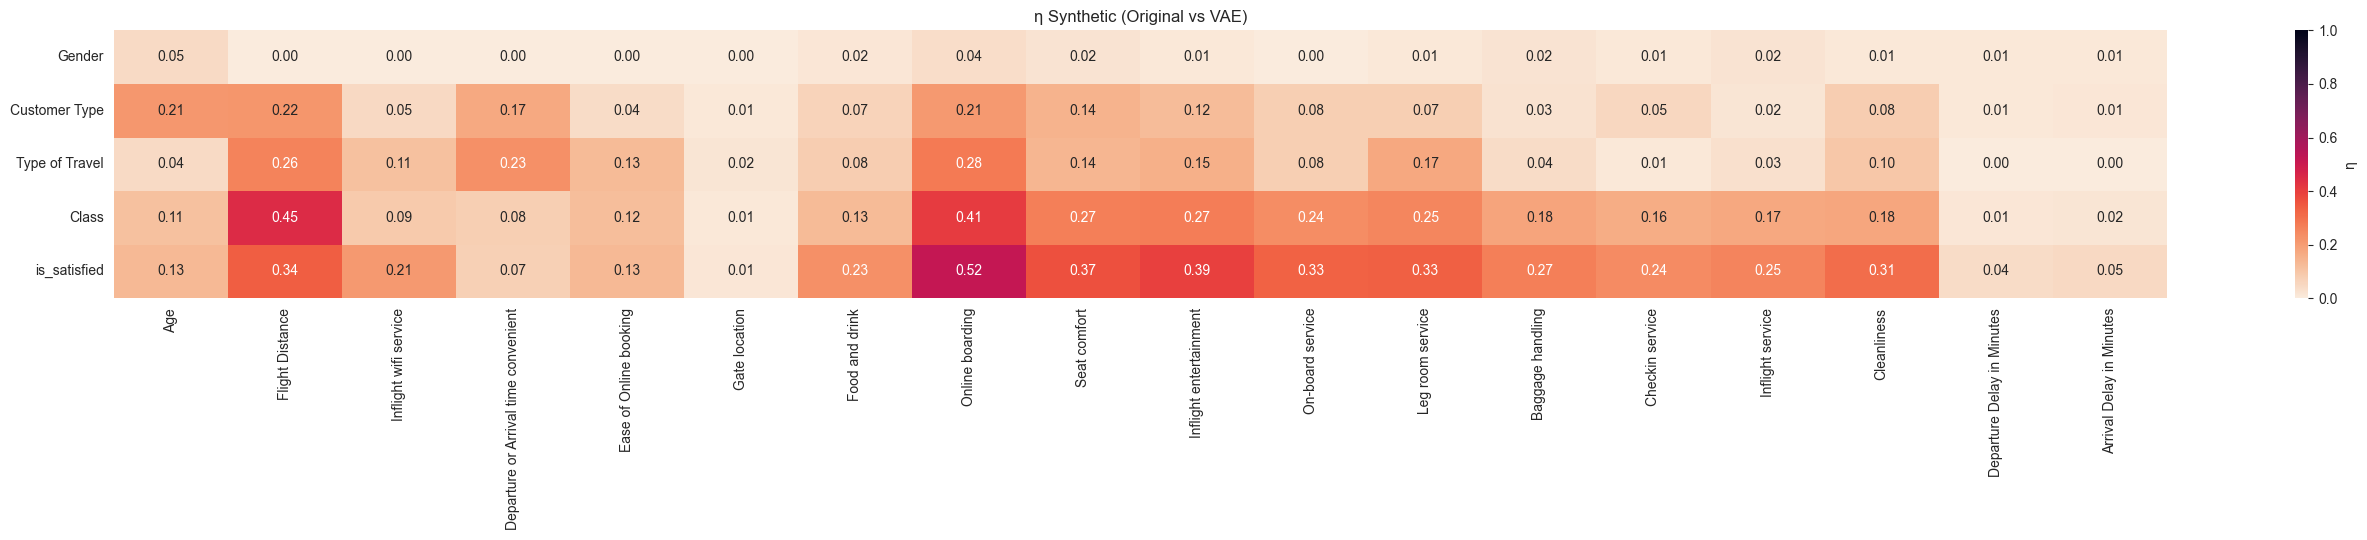

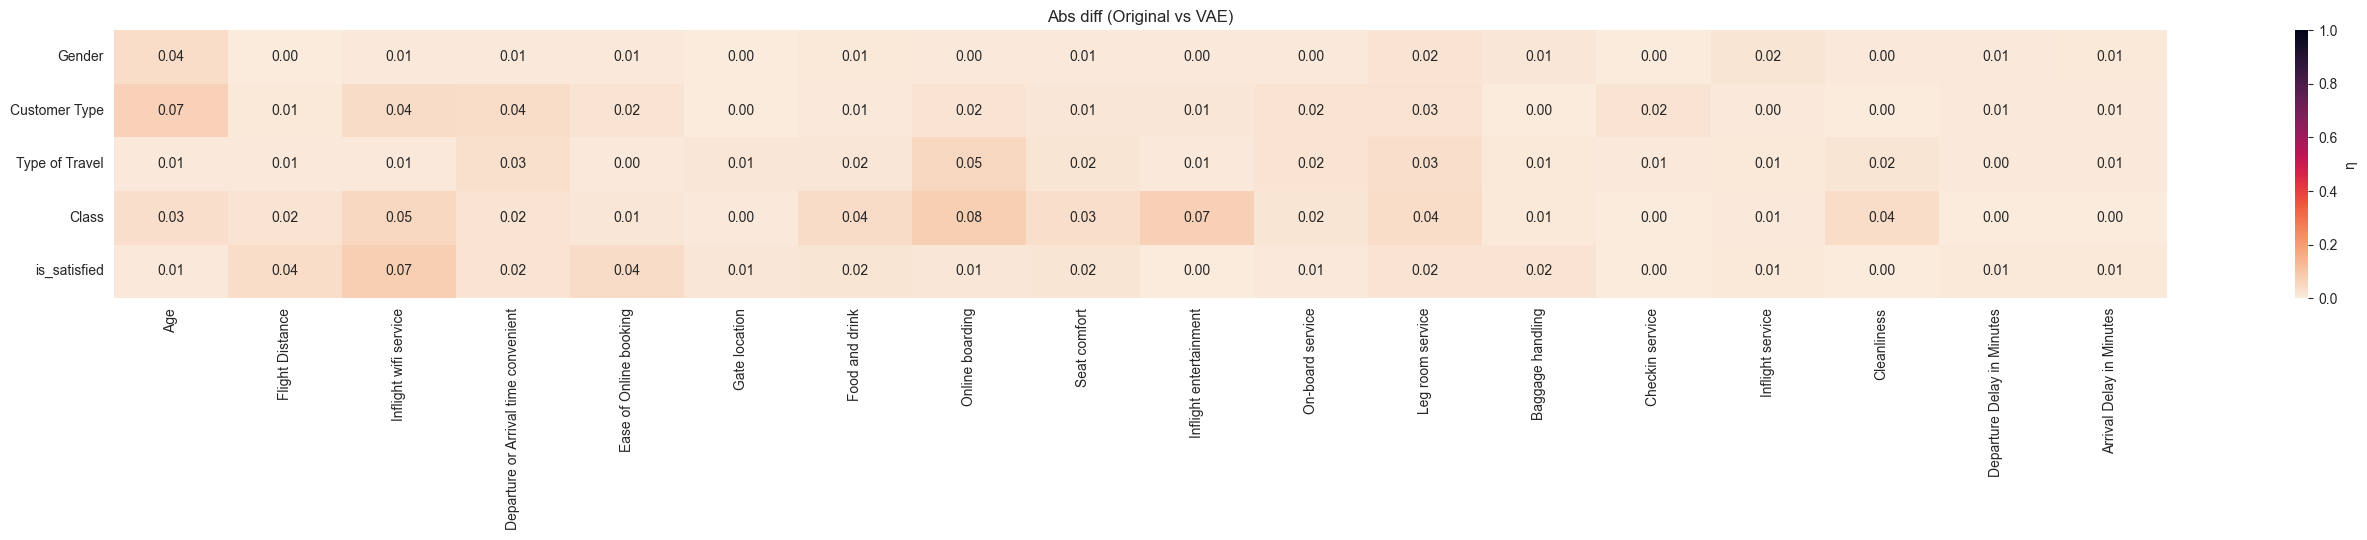

In [44]:
eta_gan = correlation_cat_num_matrix_plot(airline_dataset, airline_gan_dataset, airline_num_cols, airline_cat_cols, "Original vs GAN")
eta_vae = correlation_cat_num_matrix_plot(airline_dataset, airline_vae_dataset, airline_num_cols, airline_cat_cols, "Original vs VAE")

#### Statistical comparison of distributions of datetime columns

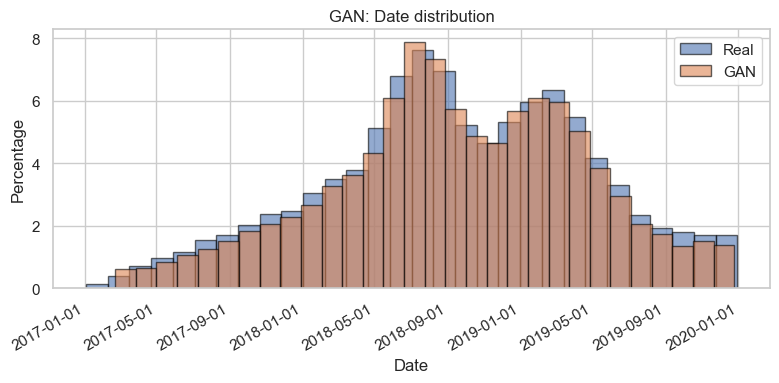

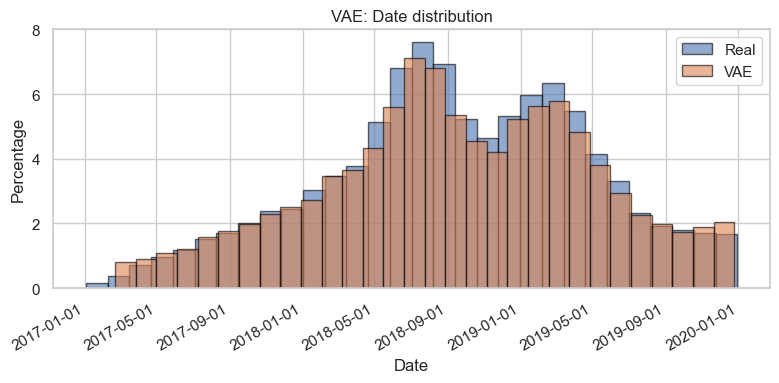

In [258]:
pairs = {
    "GAN": airline_gan_dataset,
    "VAE": airline_vae_dataset,
}

for method, synth_df in pairs.items():
    # prepare both dataframes
    dfs = {
        "Real": real_df.copy(),
        method: synth_df.copy()
    }
    for name, df in dfs.items():
        df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d', errors='coerce')
        dfs[name] = df

    fig, ax = plt.subplots(figsize=(8, 4))
    for name, df in dfs.items():
        dates = df['Date'].dropna()
        # convert to matplotlib float dates
        x = mdates.date2num(dates)
        # weights so that the sum of bar heights = 100%
        weights = np.ones_like(x) / len(x) * 100
        ax.hist(
            x,
            bins=30,
            weights=weights,
            alpha=0.6,
            label=name,
            edgecolor='black'
        )

    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    fig.autofmt_xdate(rotation=30)
    ax.set_title(f"{method}: Date distribution")
    ax.set_xlabel("Date")
    ax.set_ylabel("Percentage")
    ax.legend()
    plt.tight_layout()
    plt.show()


#### PCA plot

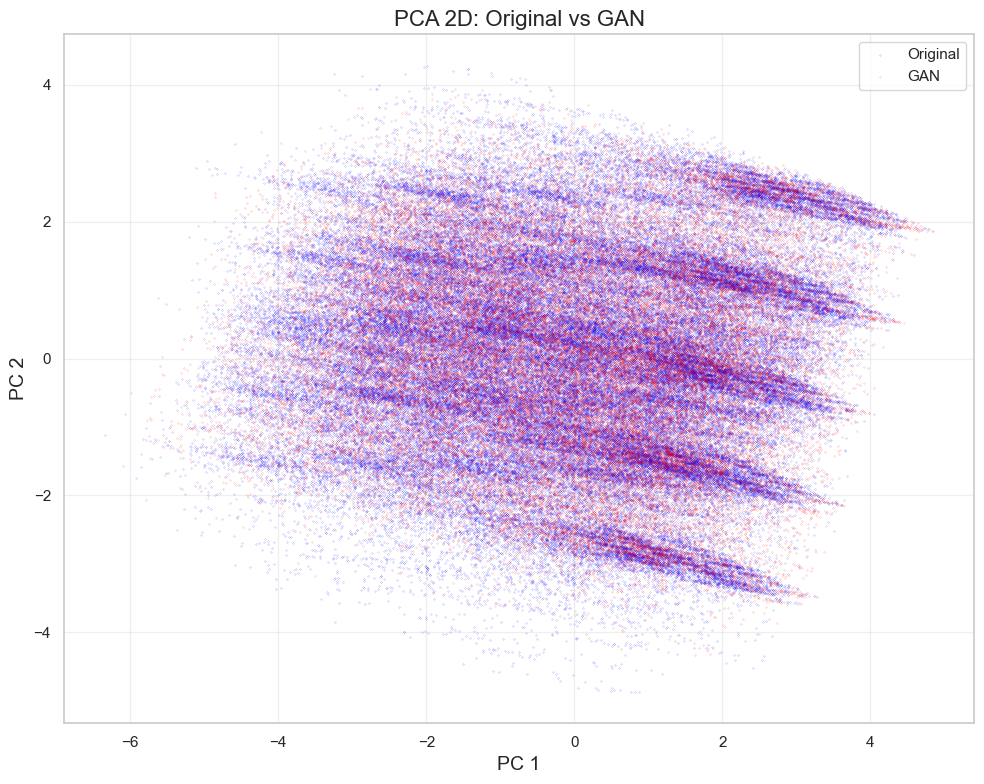

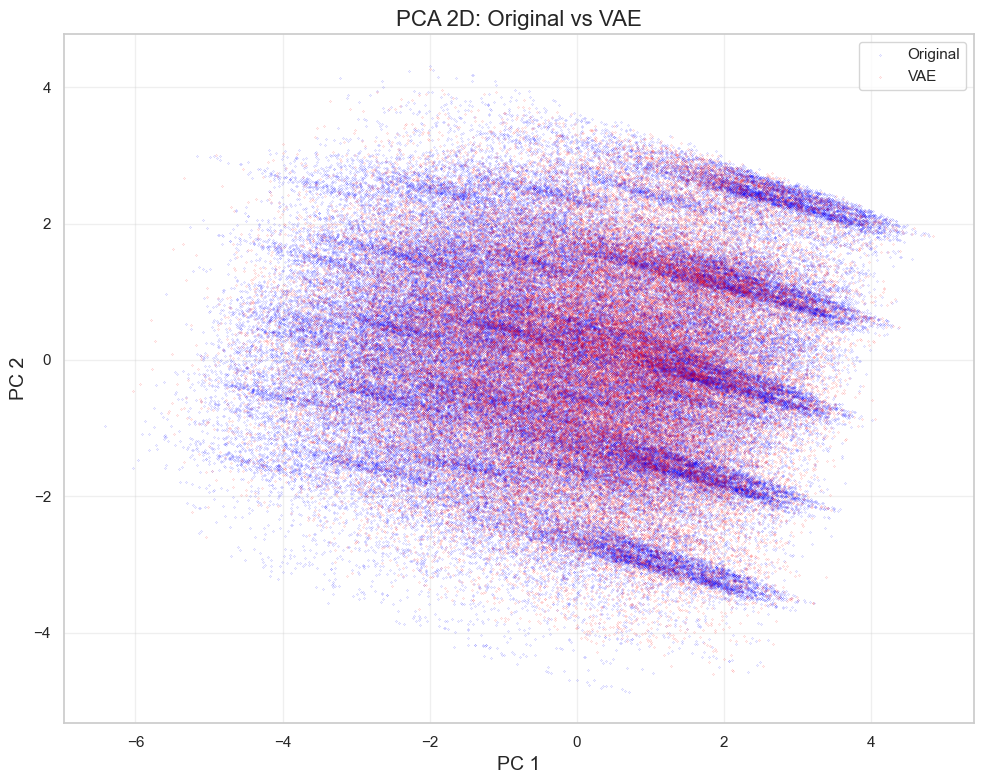

In [259]:
# Standardize original data once
X_orig = StandardScaler().fit_transform(airline_dataset[airline_num_cols].fillna(0))

# Prepare synthetic arrays (scaled with the same scaler for comparability)
scaler = StandardScaler().fit(airline_dataset[airline_num_cols].fillna(0))
X_gan = scaler.transform(airline_gan_dataset[airline_num_cols].fillna(0))
X_vae = scaler.transform(airline_vae_dataset[airline_num_cols].fillna(0))

# Plotting function
def pca_compare(X_other, label):
    X_comb = np.vstack([X_orig, X_other])
    comps = PCA(n_components=2).fit_transform(X_comb)
    n = X_orig.shape[0]
    plt.figure(figsize=(10, 8))
    plt.scatter(comps[:n,0], comps[:n,1], s=0.01, c='blue', label='Original')
    plt.scatter(comps[n:,0], comps[n:,1], s=0.01, c='red', label=label)
    plt.title(f'PCA 2D: Original vs {label}', fontsize=16)
    plt.xlabel('PC 1', fontsize=14)
    plt.ylabel('PC 2', fontsize=14)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Generate the two plots
pca_compare(X_gan, 'GAN')
pca_compare(X_vae, 'VAE')

## Discriminator of synthetic data vs original

#### Utility classes/methods for discriminator model

In [269]:
class GaussianNoise(BaseEstimator, TransformerMixin):
    def __init__(self, std=0.02, random_state=None):
        self.std = std
        self.random_state = random_state

    def fit(self, X, y=None):
        self.rng_ = np.random.RandomState(self.random_state)
        return self

    def transform(self, X):
        noise = self.rng_.normal(loc=0.0, scale=self.std, size=X.shape)
        return X + noise

    def get_feature_names_out(self, input_features=None):
        return input_features

def compute_discriminator_metrics(
    real_df, synth_df,
    n_components=10,
    noise_std=0.02,
    random_state=42
):
    # Label & stack
    a = real_df.copy()
    a['__label'] = 0
    b = synth_df.copy()
    b['__label'] = 1
    df = pd.concat([a, b], ignore_index=True)

    X = df.drop(columns='__label')
    y = df['__label']

    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, stratify=y, test_size=0.30, random_state=random_state
    )

    # Column grouping
    numeric_cols   = X.select_dtypes(include=['number', 'bool']).columns.tolist()
    categoric_cols = [c for c in X.columns if c in airline_cat_cols]

    # Pipelines
    num_pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('noise',  GaussianNoise(std=noise_std, random_state=random_state))
    ])
    cat_pipe = Pipeline([
        ('to_str', FunctionTransformer(lambda df: df.astype(str),
                                       feature_names_out='one-to-one')),
        ('ohe',    OneHotEncoder(handle_unknown='ignore', drop='first'))
    ])
    prep = ColumnTransformer([
        ('num', num_pipe, numeric_cols),
        ('cat', cat_pipe, categoric_cols)
    ], remainder='drop')

    # Full pipeline
    model = Pipeline([
        ('prep', prep),
        ('pca',  PCA(n_components=n_components, random_state=random_state)),
        ('clf',  LogisticRegression(
                     max_iter=1000,
                     C=0.1,
                     class_weight='balanced',
                     random_state=random_state))
    ])

    # Fit & predict
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)
    y_prob = model.predict_proba(X_te)[:, 1]

    # Compute metrics and auxiliary data
    metrics = {
        'Accuracy': accuracy_score(y_te, y_pred),
        'ROC AUC':  roc_auc_score(y_te, y_prob)
    }
    fpr, tpr, _ = roc_curve(y_te, y_prob)
    cm = confusion_matrix(y_te, y_pred)

    return metrics, (fpr, tpr), cm

#### Run disriminator on both synthetic datasets and compare results

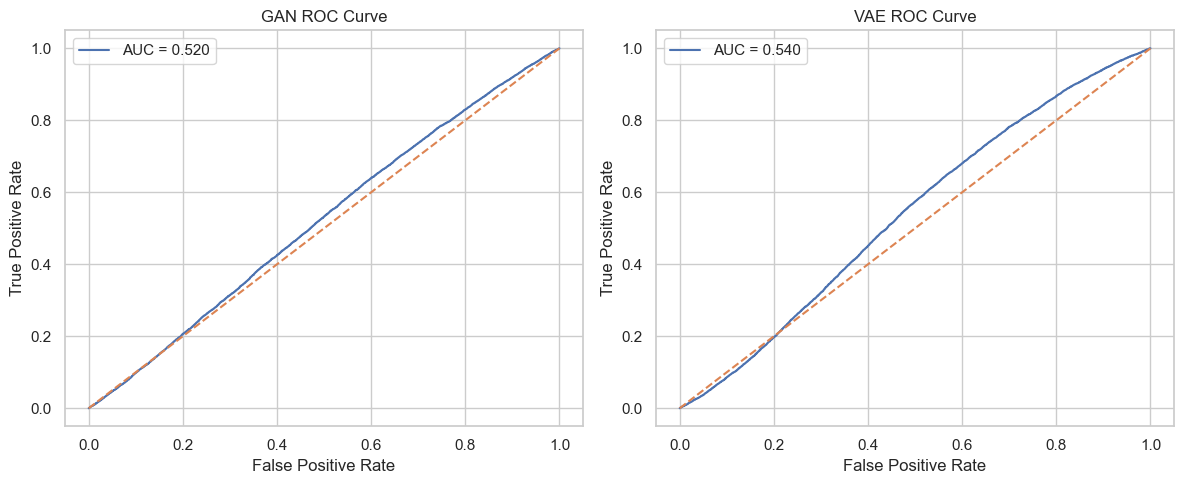

GAN Confusion Matrix interpretation:
- Of 31079 actual negatives, 15531 were correctly identified and 15548 were mislabeled.
- Of 15539 actual positives, 8290 were correctly identified and 7249 were mislabeled.

VAE Confusion Matrix interpretation:
- Of 31079 actual negatives, 14784 were correctly identified and 16295 were mislabeled.
- Of 15539 actual positives, 9329 were correctly identified and 6210 were mislabeled.



In [271]:
results = {}
roc_data = {}
cm_data  = {}

for name, synth_df in [("GAN", airline_gan_dataset), ("VAE", airline_vae_dataset)]:
    metrics, (fpr, tpr), cm = compute_discriminator_metrics(real_df, synth_df)
    results[name]  = metrics
    roc_data[name] = (fpr, tpr)
    cm_data[name]  = cm

# metrics table
metrics_df = pd.DataFrame(results).T
display(
    metrics_df.style
      .format("{:.3f}")
      .set_caption("Discriminator Performance Metrics: GAN vs VAE")
)

# 2) Side-by-side ROC curves
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for ax, name in zip(axes, results):
    fpr, tpr = roc_data[name]
    ax.plot(fpr, tpr, label=f"AUC = {results[name]['ROC AUC']:.3f}")
    ax.plot([0, 1], [0, 1], linestyle='--')
    ax.set_title(f"{name} ROC Curve")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend()
plt.tight_layout()
plt.show()

# 3) Confusion matrix interpretations one by one
for name in results:
    tn, fp, fn, tp = cm_data[name].ravel()
    print(f"{name} Confusion Matrix interpretation:")
    print(f"- Of {tn+fp} actual negatives, {tn} were correctly identified and {fp} were mislabeled.")
    print(f"- Of {fn+tp} actual positives, {tp} were correctly identified and {fn} were mislabeled.\n")


## Classification if user satisfied with airline services

#### Utility method for augment minority, evaluate

In [306]:
def auto_augment_minority(
    real_df:    pd.DataFrame,
    synth_df:   pd.DataFrame,
    feature_cols: list[str],
    cat_cols:   list[str],
    random_state: int = 42,
    disc_band:  tuple[float,float] = (0.4, 0.6)
) -> pd.DataFrame:
    # --- 1) build & train discriminator
    a = real_df.copy();  a['__label'] = 0
    b = synth_df.copy(); b['__label'] = 1
    disc_df = pd.concat([a, b], ignore_index=True)
    X_disc = pd.get_dummies(
        disc_df[feature_cols],
        columns=cat_cols,
        drop_first=True
    )
    y_disc = disc_df['__label']
    rf = RandomForestClassifier(n_estimators=100, random_state=random_state)
    rf.fit(X_disc, y_disc)

    # --- 2) filter synthetic rows by discriminator score
    X_synth_enc = pd.get_dummies(
        synth_df[feature_cols],
        columns=cat_cols,
        drop_first=True
    ).reindex(columns=X_disc.columns, fill_value=0)
    probs = rf.predict_proba(X_synth_enc)[:,1]
    mask = (probs >= disc_band[0]) & (probs <= disc_band[1])
    good_synth = synth_df.loc[mask].copy()
    if good_synth.empty:
        print('good_synth.empty')
        # fallback: if nothing in band, use full synth_df
        good_synth = synth_df.copy()

    # --- 3) group‐wise topping up
    np.random.seed(random_state)
    augmented = real_df.copy()
    for col in cat_cols:
        counts = augmented[col].value_counts()
        majority = counts.max()
        for cls, cnt in counts.items():
            if cnt < majority:
                to_add = majority - cnt
                pool = good_synth[good_synth[col] == cls]
                if pool.empty:
                    continue
                sampled = pool.sample(n=to_add,
                                      replace=True,
                                      random_state=random_state)
                augmented = pd.concat([augmented, sampled], ignore_index=True)

    return augmented



def evaluate(train_X, train_y, cat_cols):
    # 1) One-hot encode categoricals
    X_tr_enc = pd.get_dummies(train_X, columns=[c for c in cat_cols if c in train_X.columns], drop_first=True)
    X_te_enc = pd.get_dummies(X_test, columns=[c for c in cat_cols if c in train_X.columns], drop_first=True)
    # Align columns (fill missing with 0)
    X_te_enc = X_te_enc.reindex(columns=X_tr_enc.columns, fill_value=0)

    # Train & score
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.set_params(
        n_estimators=300,
        max_depth=None,
        max_features=0.3,
        min_samples_leaf=1
    )
    clf.fit(X_tr_enc, train_y)
    preds = clf.predict(X_te_enc)
    probs = clf.predict_proba(X_te_enc)[:, 1]
    return {
        'ROC AUC':  roc_auc_score(y_test, probs),
        'F1 score': f1_score(y_test, preds)
    }

In [307]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score

target_col = 'is_satisfied'

cat_cols = [c for c in airline_cat_cols if c != target_col]

for df in (airline_dataset, airline_gan_dataset, airline_vae_dataset):
    df[target_col] = df[target_col].astype(int)

# Select feature columns (numeric + categorical, except target)
feature_cols = [c for c in airline_dataset.columns if c in airline_num_cols + airline_cat_cols and c != target_col]

# 1) Split real data once
X = airline_dataset[feature_cols]
y = airline_dataset[target_col]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# 2) Build your train-only DF for augmentation
train_real = X_train.copy()
train_real[target_col] = y_train.values

# 3) Prepare container
results = {}

# Baselines (no change)
results['Real only'] = evaluate(X_train, y_train, cat_cols)

X_gan = pd.concat([X_train, airline_gan_dataset[feature_cols]], ignore_index=True)
y_gan = pd.concat([y_train, airline_gan_dataset[target_col]], ignore_index=True)
results['Real + GAN'] = evaluate(X_gan, y_gan, cat_cols)

X_vae = pd.concat([X_train, airline_vae_dataset[feature_cols]], ignore_index=True)
y_vae = pd.concat([y_train, airline_vae_dataset[target_col]], ignore_index=True)
results['Real + VAE'] = evaluate(X_vae, y_vae, cat_cols)

# 4) Auto-augment **only** the train split
aug_train_gan = auto_augment_minority(
    real_df      = train_real,
    synth_df     = airline_gan_dataset,
    feature_cols = feature_cols,
    cat_cols     = cat_cols,
    disc_band    = (0.4, 0.6),
    random_state = 42
)
X_train_gan = aug_train_gan[feature_cols]
y_train_gan = aug_train_gan[target_col]
results['Real + GAN (auto-aug)'] = evaluate(X_train_gan, y_train_gan, cat_cols)

aug_train_gan = auto_augment_minority(
    real_df      = train_real,
    synth_df     = airline_vae_dataset,
    feature_cols = feature_cols,
    cat_cols     = cat_cols,
    disc_band    = (0.4, 0.6),
    random_state = 42
)
X_train_vae = aug_train_vae[feature_cols]
y_train_vae = aug_train_vae[target_col]
results['Real + VAE (auto-aug)'] = evaluate(X_train_vae, y_train_vae, cat_cols)

# 5) Show
display(pd.DataFrame(results).T)

ROC AUC  F1 score
Real only              0.994256  0.956469
Real + GAN             0.992091  0.950623
Real + VAE             0.992032  0.949657
Real + GAN (auto-aug)  0.994142  0.955457
Real + VAE (auto-aug)  0.990959  0.946564

# Household Power Consumption Dataset

## Preprocessing and data generation

##### Metadata for synthetic generation

In [3]:
household_dataset_metadata = {
    'Date_time': FieldMetadata(data_type=DataType.DATETIME, datetime_format='%Y-%m-%d %H:%M:%S'),
    'Global_active_power': FieldMetadata(data_type=DataType.DECIMAL, decimal_places=3),
    'Global_reactive_power': FieldMetadata(data_type=DataType.DECIMAL, decimal_places=3),
    'Voltage': FieldMetadata(data_type=DataType.DECIMAL, decimal_places=2),
    'Global_intensity': FieldMetadata(data_type=DataType.DECIMAL, decimal_places=1),
    'Sub_metering_1': FieldMetadata(data_type=DataType.DECIMAL, decimal_places=1),
    'Sub_metering_2': FieldMetadata(data_type=DataType.DECIMAL, decimal_places=1),
    'Sub_metering_3': FieldMetadata(data_type=DataType.DECIMAL, decimal_places=1),
}

In [5]:
household_dataset_num_cols = [key for key, value in household_dataset_metadata.items() if value.data_type in (DataType.DECIMAL, DataType.INTEGER)]

##### Loading and preprocessing a dataset for training neural networks

In [8]:
def load_household_dataset(csv_path:str):
    # Loading dataset
    raw = pd.read_csv(
        csv_path,
        sep=';',
        dayfirst=True,
        na_values='?'
    )
    # Parse datetime explicitly to avoid FutureWarning
    raw['Date_time'] = pd.to_datetime(
        raw['Date'].str.strip() + ' ' + raw['Time'].str.strip(),
        format='%d/%m/%Y %H:%M:%S',
        dayfirst=True,
        errors='coerce'
    )
    # Drop rows where parsing failed
    df_power = raw.dropna(subset=['Date_time']).drop(columns=['Date', 'Time'])

    df_power = df_power.set_index('Date_time').sort_index()
    # Resample to an explicit hourly index
    df_hourly = df_power.resample('h').sum()
    # Interpolate missing hours by time
    df_hourly_interp = df_hourly.interpolate(method='time')
    # interpolate numeric columns
    df_hourly_interp[household_dataset_num_cols] = df_hourly[household_dataset_num_cols].interpolate(method='time')
    # form final dataset for training
    return df_hourly_interp.reset_index()

household_dataset = load_household_dataset('datasets/household_power_consumption.csv')
print(f"Rows count in dataset: {household_dataset.shape[0]}")
print(f"Column amount: {household_dataset.shape[1]}")
display(household_dataset.head())

Loaded hourly data shape: (34589, 8)


Date_time  Global_active_power  Global_reactive_power   Voltage  \
0 2006-12-16 17:00:00              152.024                  8.244   8447.18   
1 2006-12-16 18:00:00              217.932                  4.802  14074.81   
2 2006-12-16 19:00:00              204.014                  5.114  13993.95   
3 2006-12-16 20:00:00              196.114                  4.506  14044.29   
4 2006-12-16 21:00:00              183.388                  4.600  14229.52   

   Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
0             651.6             0.0            19.0           607.0  
1             936.0             0.0           403.0          1012.0  
2             870.2             0.0            86.0          1001.0  
3             835.0             0.0             0.0          1007.0  
4             782.8             0.0            25.0          1033.0

##### Data generation using GAN and VAE neural networks

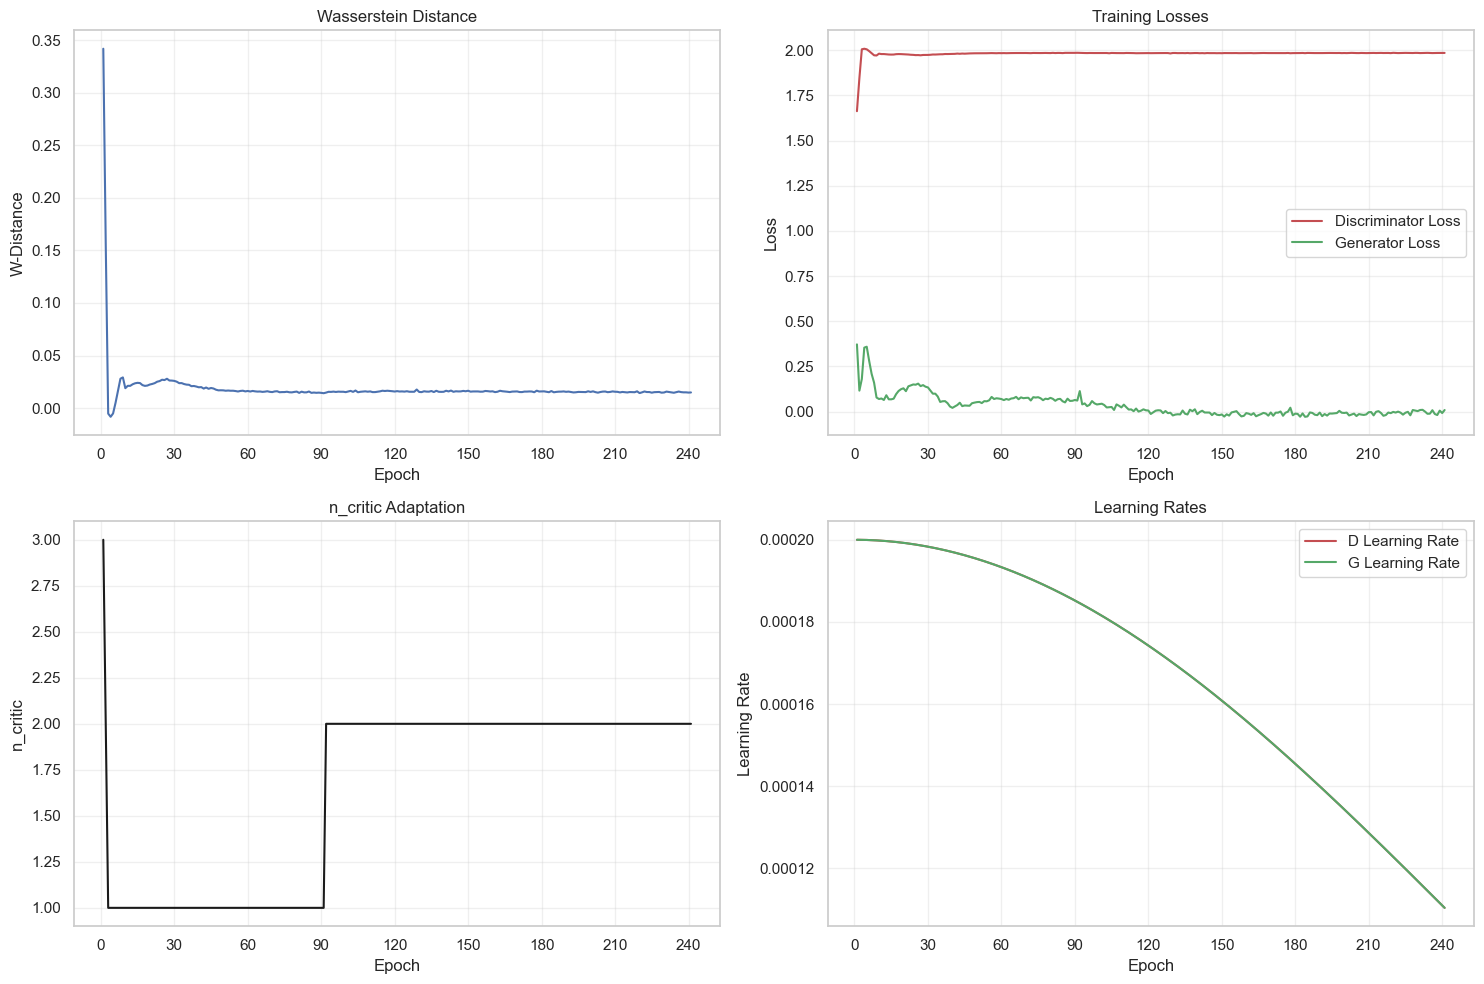

In [9]:
cfg = GanConfig(
    epochs=500, patience=240, g_lr=2e-4, d_lr=2e-4,
    use_hinge=True, use_fm_loss=True,  fm_w=10.0,
    use_cov_loss=True, cov_w=2.0,
    use_delta_loss=True, delta_w=5.0,
    use_bias_correction=True,
)
gan_full = GAN(household_dataset, household_dataset_metadata, cfg)
gan_full.fit(verbose=True)
S_gan_full = gan_full.generate(len(household_dataset), temperature=0.7)

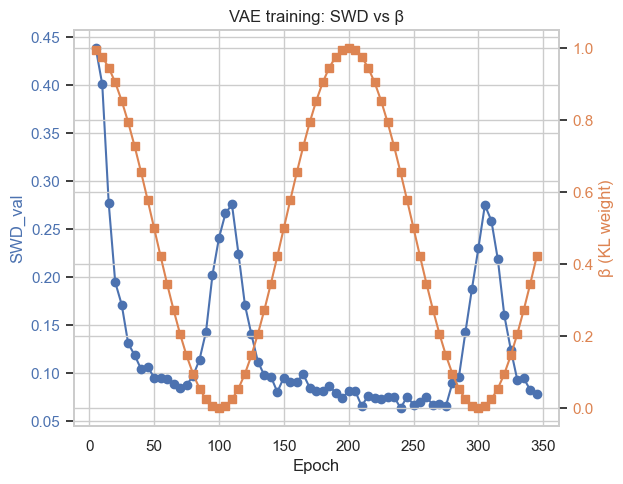

In [10]:
vae_full = VAE(household_dataset, household_dataset_metadata)
vae_full.fit(epochs=400, verbose=True)
S_vae_full = vae_full.generate(len(household_dataset))

##### Statistical analysis of synthetic data

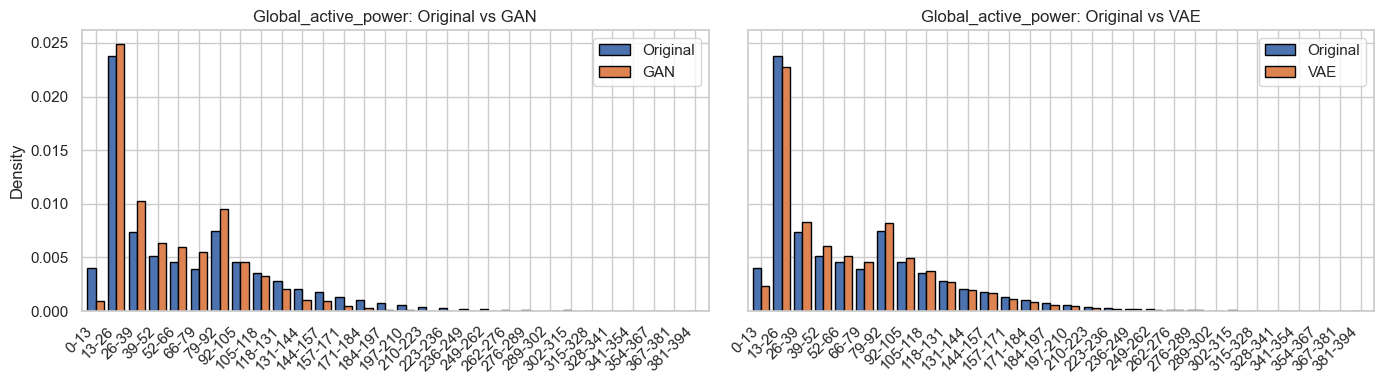

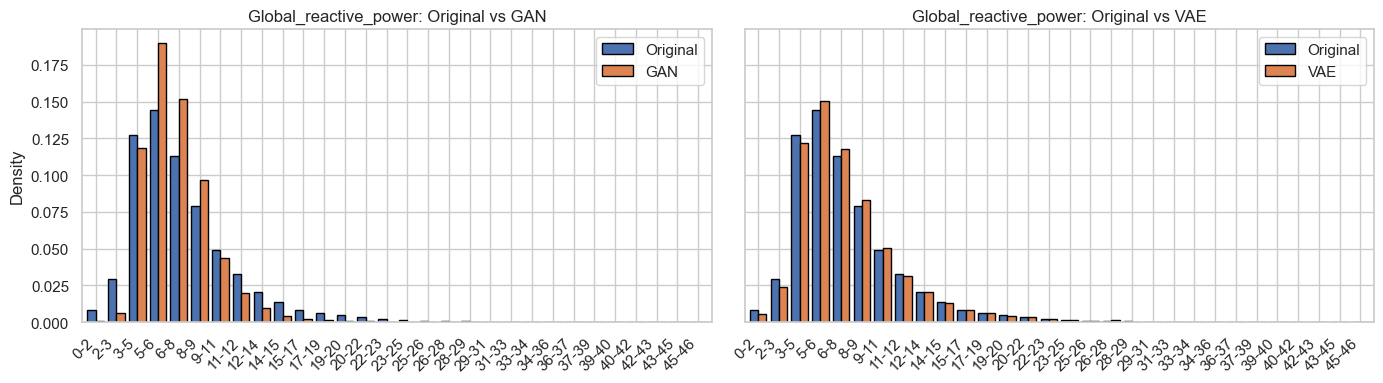

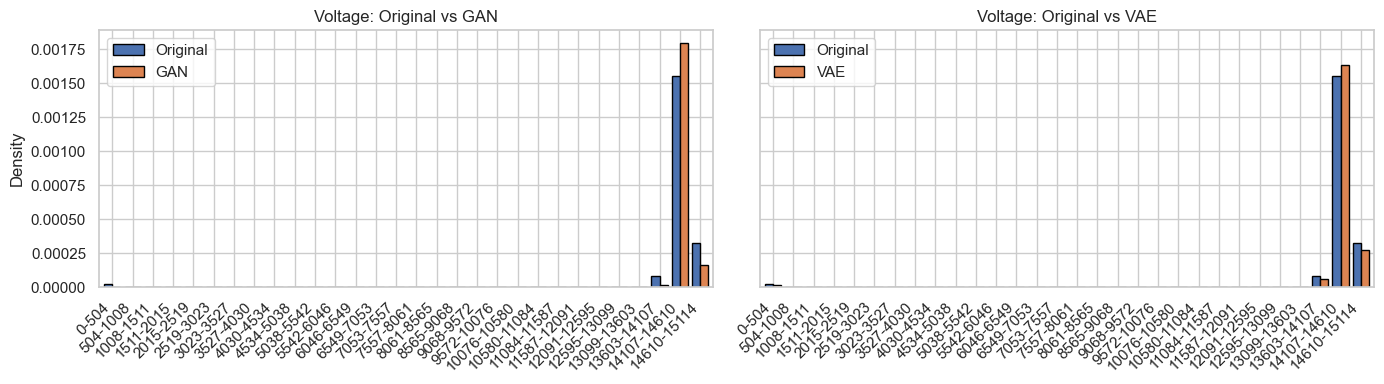

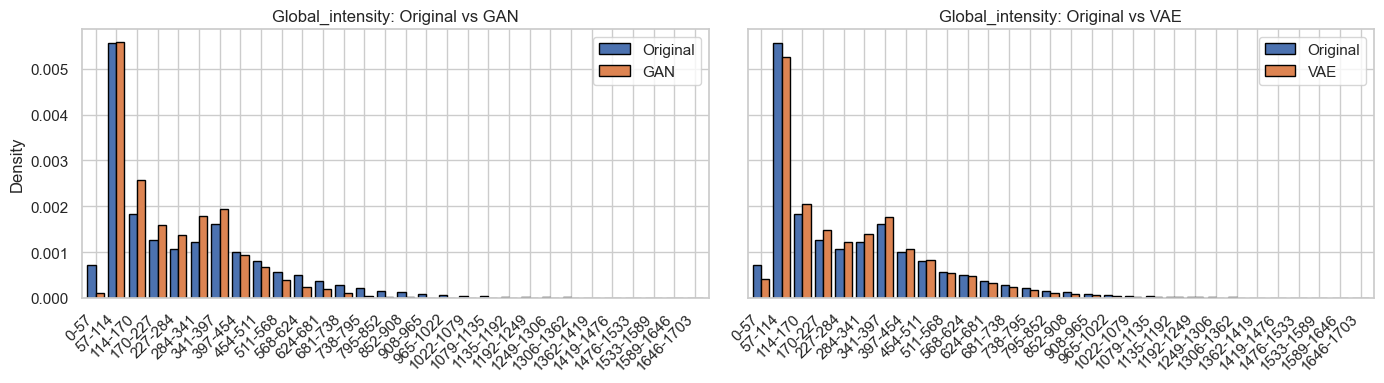

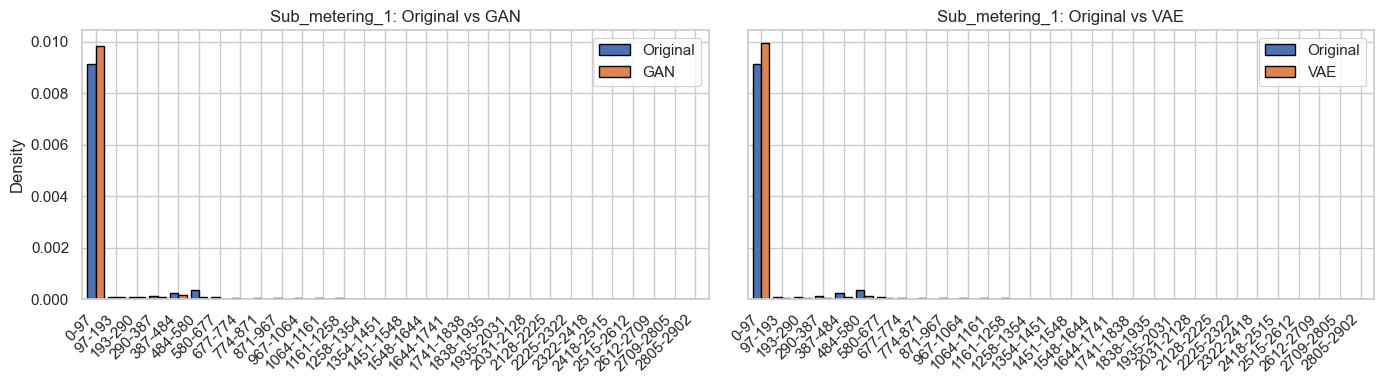

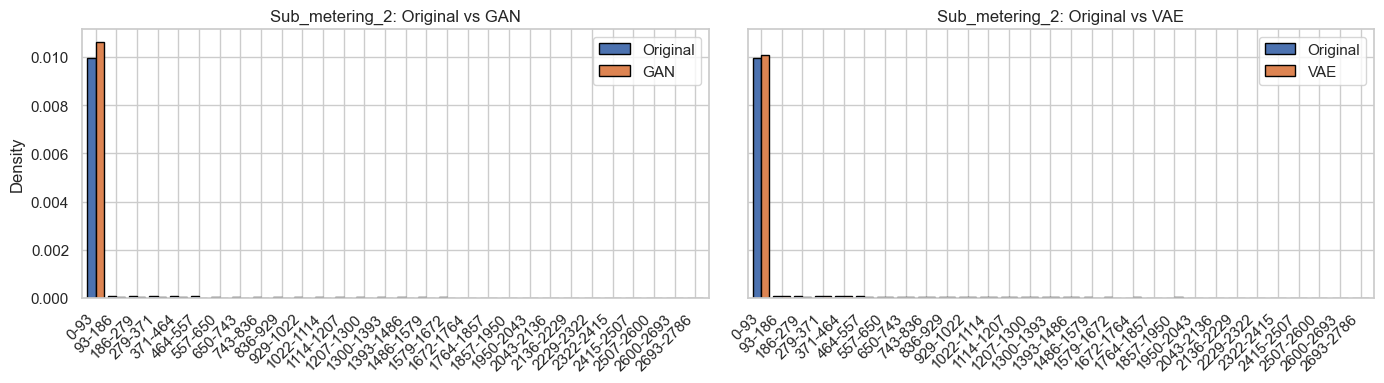

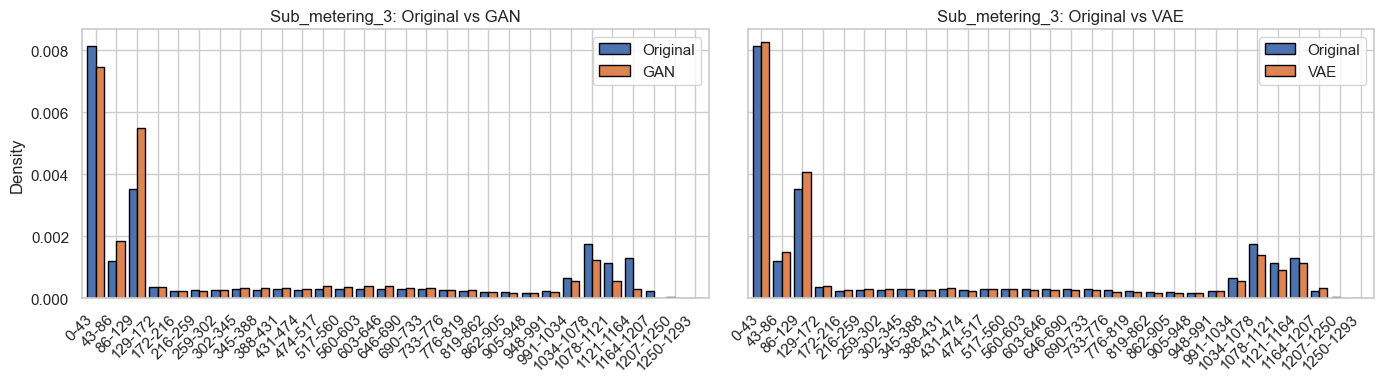

In [210]:
for col in [key for key, value in household_dataset_metadata.items() if value.data_type in (DataType.DECIMAL, DataType.INTEGER)]:
    orig_vals = household_dataset[col].dropna().values
    gan_vals  = S_gan_full[col].dropna().values
    vae_vals  = S_vae_full[col].dropna().values

    # Define common bins based on original data
    bins = np.histogram_bin_edges(orig_vals, bins=30)

    # Compute a normalized histogram (density) for each dataset
    orig_counts, _ = np.histogram(orig_vals, bins=bins, density=True)
    gan_counts,  _ = np.histogram(gan_vals,  bins=bins, density=True)
    vae_counts, _ = np.histogram(vae_vals, bins=bins, density=True)

    # Create bin labels
    bin_labels = [f"{bins[i]:.0f}-{bins[i+1]:.0f}" for i in range(len(bins)-1)]

    # Build DataFrames for plotting
    df_og = pd.DataFrame({'Original': orig_counts, 'GAN': gan_counts}, index=bin_labels)
    df_ov = pd.DataFrame({'Original': orig_counts, 'VAE': vae_counts}, index=bin_labels)

    # Plot side-by-side bar charts
    fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)

    df_og.plot(kind='bar', ax=axes[0], width=0.8, edgecolor='black')
    axes[0].set_title(f"{col}: Original vs GAN")
    axes[0].set_ylabel('Density')

    df_ov.plot(kind='bar', ax=axes[1], width=0.8, edgecolor='black')
    axes[1].set_title(f"{col}: Original vs VAE")

    for ax in axes:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        ax.legend()
    plt.tight_layout()
    plt.show()

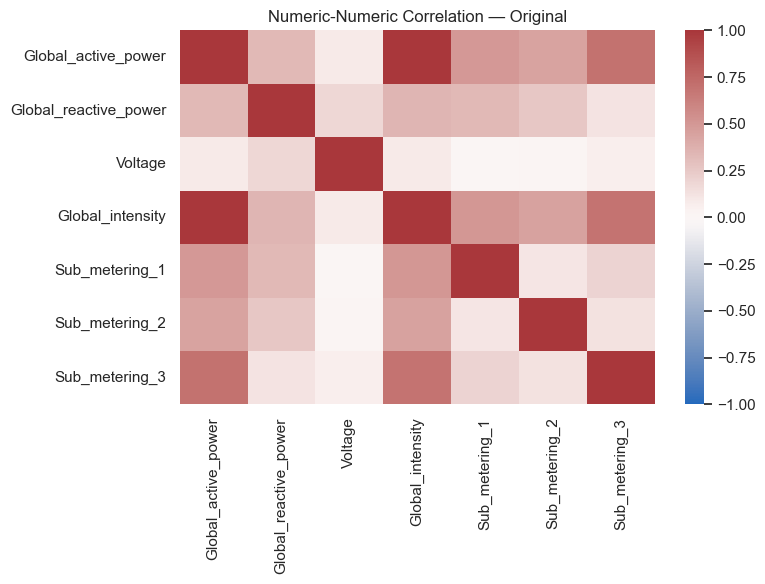

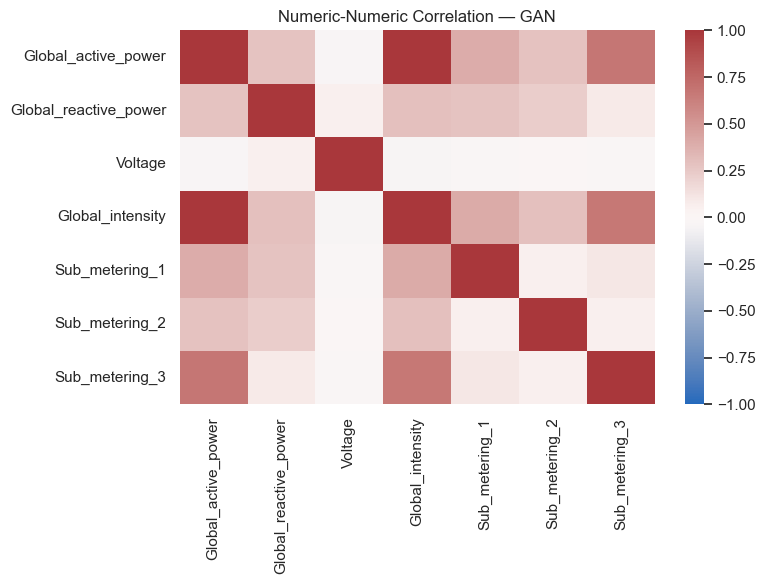

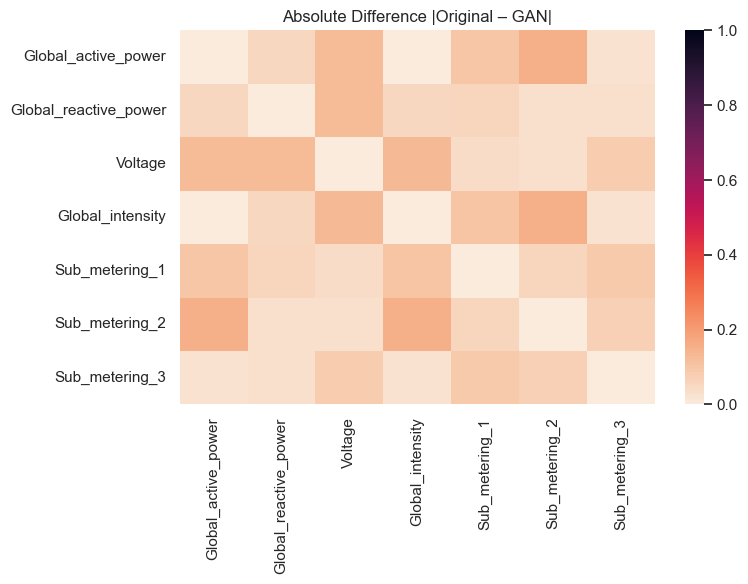

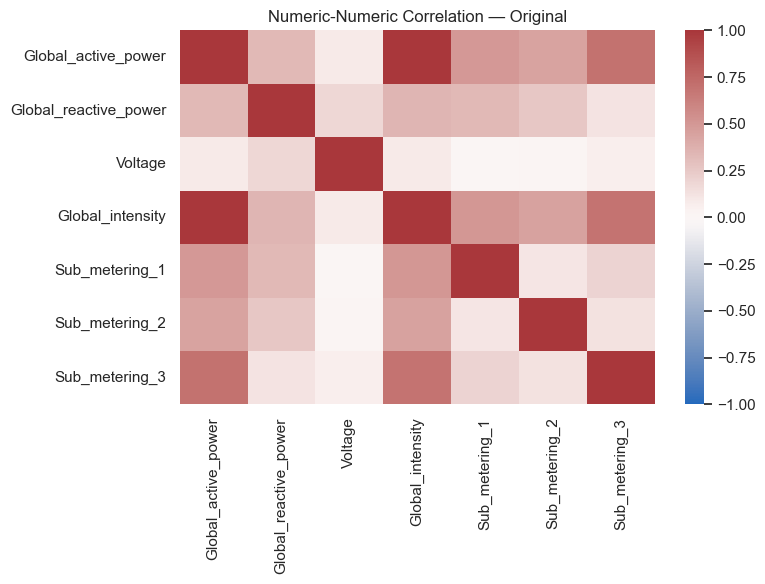

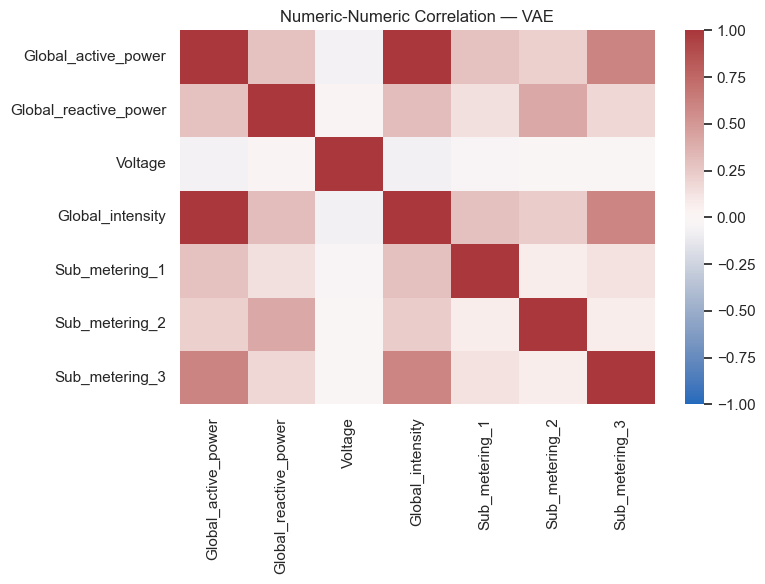

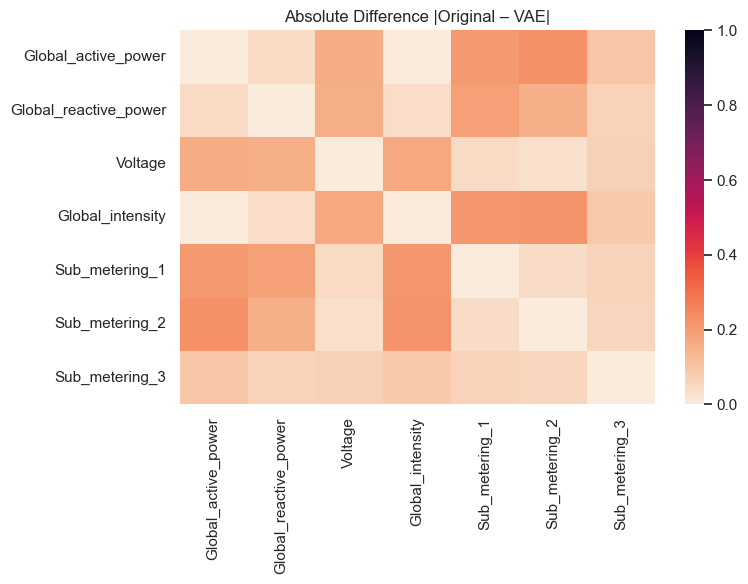

In [214]:
correlation_num_to_num_matrix_plot(
    household_dataset,
    S_gan_full,
    [key for key, value in household_dataset_metadata.items() if value.data_type in (DataType.DECIMAL, DataType.INTEGER)],
    "GAN")
correlation_num_to_num_matrix_plot(
    household_dataset,
    S_vae_full,
    [key for key, value in household_dataset_metadata.items() if value.data_type in (DataType.DECIMAL, DataType.INTEGER)],
    "VAE")

## 8. Short‑Term Forecasting with ARIMA

### Load & pre-process the real series

In [308]:
df = pd.read_csv("datasets/household_power_consumption.csv", sep=";", na_values="?", low_memory=False)
df["Date_time"] = pd.to_datetime(
    df["Date"].str.strip() + " " + df["Time"].str.strip(),
    format="%d/%m/%Y %H:%M:%S", dayfirst=True, errors="coerce"
)
y_hour = (
    df.dropna(subset=["Date_time"])
      .set_index("Date_time")["Global_active_power"]
      .resample("h").sum()
      .interpolate("time")
)

MAPE    RMSE
Original   0.836  43.344
ARIMA+GAN  0.740  42.961
ARIMA+VAE  0.734  43.631

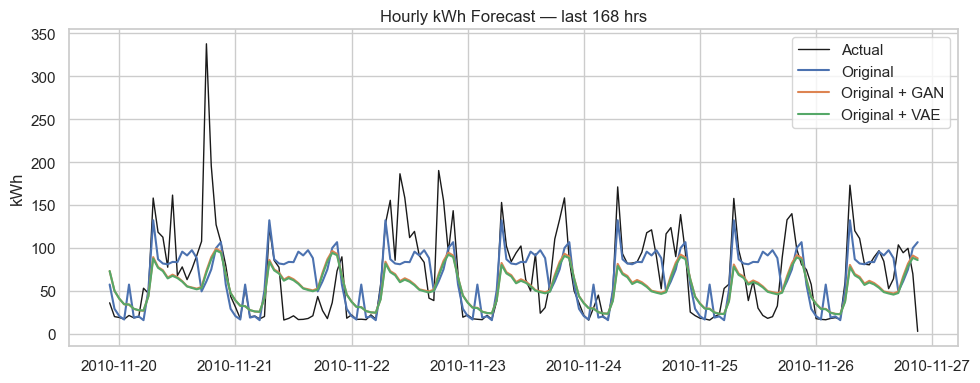

In [215]:
# ignore only the SARIMAX convergence warnings
warnings.simplefilter("ignore", UserWarning)

# ─── 1) Split real data into train / test ─────────────────────────────────
train_orig = y_hour.iloc[:-TEST_H]
test_y     = y_hour.iloc[-TEST_H:]

gan_vals = (
    S_gan_full
    .set_index('Date_time')['Global_active_power']
    .astype(float)
    .sort_index()
)
vae_vals = (
    S_vae_full
    .set_index('Date_time')['Global_active_power']
    .astype(float)
    .sort_index()
)

# ─── 2) Build small GAN/VAE “blocks” and prepend them ────────────────────
train_len  = len(train_orig)
block_len  = train_len

gan_block  = gan_vals.iloc[:block_len]
vae_block  = vae_vals.iloc[:block_len]

start_ts   = train_orig.index[0]
gan_series = pd.Series(
    gan_block.values,
    index=pd.date_range(end=start_ts - pd.Timedelta(hours=1), periods=block_len, freq="h")
)
vae_series = pd.Series(
    vae_block.values,
    index=pd.date_range(end=start_ts - pd.Timedelta(hours=1), periods=block_len, freq="h")
)

train_gan_ext = pd.concat([gan_series, train_orig]).sort_index()
train_vae_ext = pd.concat([vae_series, train_orig]).sort_index()

# ─── 3) Box–Cox transform all three histories (reuse λ) ────────────────
eps        = 1e-6
bc_base    = pd.Series(boxcox(train_orig + eps,   lmbda=lam), index=train_orig.index)
bc_gan_ext = pd.Series(boxcox(train_gan_ext + eps, lmbda=lam), index=train_gan_ext.index)
bc_vae_ext = pd.Series(boxcox(train_vae_ext + eps, lmbda=lam), index=train_vae_ext.index)

# ─── 4) Fit three SARIMAX models ────────────────────────────────────────
# 4a) “Weakened” ARIMA on original only
cutoff    = int(len(bc_base)*0.999)
y_weak    = bc_base.iloc[cutoff:].asfreq("h")
mod_orig  = SARIMAX(
    y_weak,
    order=(1,0,2),
    seasonal_order=(0,1,1,24),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

# Full ARIMA on GAN-extended history
ORDER, SORDER = (2,0,2), (1,1,1,24)
mod_gan       = SARIMAX(
    bc_gan_ext.asfreq("h"),
    order=ORDER,
    seasonal_order=SORDER,
    initialization="approximate_diffuse"
).fit(disp=False)

# Full ARIMA on VAE-extended history
mod_vae       = SARIMAX(
    bc_vae_ext.asfreq("h"),
    order=ORDER,
    seasonal_order=SORDER,
    initialization="approximate_diffuse"
).fit(disp=False)

# Forecast the hold-out
pred_orig_bc = mod_orig .forecast(steps=TEST_H)
pred_gan_bc  = mod_gan  .forecast(steps=TEST_H)
pred_vae_bc  = mod_vae  .forecast(steps=TEST_H)

# align indexes to the real test
pred_orig_bc.index = test_y.index
pred_gan_bc .index = test_y.index
pred_vae_bc .index = test_y.index

# Invert Box–Cox back to kWh
inv_bc = lambda x: np.exp(x) if lam==0 else (x*lam + 1)**(1/lam)
pred_orig = pd.Series(inv_bc(pred_orig_bc), index=test_y.index, name="Original")
pred_gan  = pd.Series(inv_bc(pred_gan_bc),  index=test_y.index, name="ARIMA+GAN")
pred_vae  = pd.Series(inv_bc(pred_vae_bc),  index=test_y.index, name="ARIMA+VAE")

# Compute and display metrics
scores = pd.DataFrame({
    "MAPE": [
        mean_absolute_percentage_error(test_y, pred_orig),
        mean_absolute_percentage_error(test_y, pred_gan),
        mean_absolute_percentage_error(test_y, pred_vae),
    ],
    "RMSE": [
        np.sqrt(mean_squared_error(test_y, pred_orig)),
        np.sqrt(mean_squared_error(test_y, pred_gan)),
        np.sqrt(mean_squared_error(test_y, pred_vae)),
    ]
}, index=["Original","ARIMA+GAN","ARIMA+VAE"])
display(scores.round(3))

# Plot all three forecasts against actual
plt.figure(figsize=(10,4))
plt.plot(test_y,       label="Actual",                   color="k", linewidth=1)
plt.plot(pred_orig,    label="Original")
plt.plot(pred_gan,     label="Original + GAN")
plt.plot(pred_vae,     label="Original + VAE")
plt.title(f"Hourly kWh Forecast — last {TEST_H} hrs")
plt.ylabel("kWh")
plt.legend()
plt.tight_layout()
plt.show()